# CAO Project Outline
---

This notebook contains:
 -  An overview of how to load CAO points information from the CAO website
 -  Appropriate plots and other visualisations of the data
 
As the data from the CAO are not synonymous for comparing the 2021 and 2020 data to the data from years previous I will group the 2021 and 2020 data together for analysis and then group 2019 to 2017 (inclusive) together for analysis. 
For the years 2019 to 2017 I will not be examining EOS and will be focusing on Mid instead.

# Background on the CAO
___

The Central Applications Office (CAO), founded in January 1976, is the organisation responsible for overseeing undergraduate applications to colleges and universities in the Republic of Ireland<sup>1</sup>. 
Undergraduates apply for entry into university through the CAO website and not through individual universities. The CAO is a points based system, with students getting the highest points securing offers from universities.

## Leaving Certificate Points
The points obtained from the leaving certificate exam determine what course the student is eligible for. Points for higher and ordinary level shown below<sup>2</sup>.

***Higher Level Points***

| Higher Level Grade | Points |
| -- | -- |
| H1 | 100|
| H2 | 88 |
| H3 | 77 |
| H4 | 66 |
| H5 | 56 |
| H6 | 46 |
| H7 | 37 |
| H8 | 0 |

***Ordinary Level Points***

| Ordinary Level Grade | Points |
| -- | -- |
| O1 | 56 |
| O2 | 46 |
| O3 | 37 |
| O4 | 28 |
| O5 | 20 |
| O6 | 12 |
| O7 | 0 |
| O8 | 0 |

A students points are calculated based on their six best subjects for a maximum score of 625, if the student takes and passes higher level maths<sup>2</sup>.

Adding table of contents using the code below

In [1]:
#  !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install --user

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Importing the Required Libraries
---

In [3]:
# Regualar expressions
import re

# Convient HTTP requests
import requests as rq

# Dates and times
import datetime as dt

import os

# Data frames
import pandas as pd

# For downloading
import urllib.request as urlrq

# Nice plots
import seaborn as sns

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

# Saving the datasets
---

It is best practice to save the dataset each time the data is ran, this ensures if the data on the websites is changed then the dataset will reflect these changes. In order for each save to not overwrite the previous version datetime is used.

In [4]:
# Get current date and time
now = dt.datetime.now()

# Format as a string
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

# Obtaining the Data 
-----

## Obtaining 2021 Data

The [2021 course points](http://www2.cao.ie/points/l8.php) for level 8 courses.

```Resquests``` allows you to send HTTP/1.1 requests extremely easily<sup>3</sup>. ```resp``` is the response object from which we get all the information we need<sup>4</sup>. The HTTP ```<Respoonse [200]>``` success status response code indicates that the request has succeeded<sup>5</sup>.

In [5]:
# Use resp.text to see the text
resp = rq.get('http://www2.cao.ie/points/l8.php')

# peak
resp

<Response [200]>

In [6]:
# Create a filepath for the original data
# Always sort year, month, date
pathhtml= 'data/CAO2021_' + nowstr + '.html'

### Error on Server

Technically, the server says we should decode as per:
> Content-Type: text/html; charset=iso-8859-1

However one line uses \x96 which isn't defined in iso-8859-1
Therefore we use the similar decoding standard cp1252.

utf-8 usual decode but since Irish uses fadas you must decode using iso-8859-1 so it's not written in utf-8. Inspect the webpage and then it shows you the source code and network. In network headers you can see that the character set used is iso-8859-1.

In [7]:
# Server uses wrong encoding
original_encoding = resp.encoding

# Change to cp1252
resp.encoding = 'cp1252'

In [8]:
# Save original html file
with open(pathhtml, 'w') as f:
    f.write(resp.text)

### Regular Expressions

Regular expressions can be used to clean the dataset. These work by searching and matching using a sequence if characters that the user specifies. Regular expressions can be used to remove rows/spaces/whitespaces that are not required. Below is the regular expression used to clean this dataset.
```(r'([A-Z]{2}[0-9]{3})  (.*)')```
The first part of this code ```(r'(``` denotes a raw string, followed by ```[A-Z]{2}``` which means any two capital letters between A and Z, followed by ```[0-9]{3}``` which looks for 3 numbers between 0 and 9 immediately after the two letters and finally ```(.*)')``` this looks for a wildcard (an unknown number of any character).

In [9]:
#Compile the regular expression for matching lines
re_course = re.compile(r'([A-Z]{2}[0-9]{3})  (.*)')

### Creating the filepath


In [10]:
# The file path for the csv file.
path2021 = 'data/cao2021_csv_' + nowstr + '.csv'

In [11]:
# Keep track of how many courses we process.
no_lines=0

# Open the csv file for writing.
with open(path2021, 'w') as f:
    #Write a header row
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')
    for line in resp.iter_lines():
        dline = line.decode('cp1252')
        # Match only the lines we want - the ones representing courses.
        #if re.fullmatch('[A-Z]{2}[0-9]{3}  .*[0-9]{3}(\*)? *', line.decode('iso-8859-1')):
        if re_course.fullmatch(dline):
            no_lines = no_lines + 1
            #print(line)
            #csv_version = re_course.sub(r'\1,\2,\3\4', dline)
            #print(csv_version)
            #linesplit = re.split('  +', dline)
            # debug
            #print(len(linesplit), linesplit, dline)
            course_code = dline[:5]
            #print(course_code)
            course_title = dline[7:57].strip()
            # Round one points
            course_points = re.split(' +', dline[60:])
            if len(course_points) !=2:
            #print(f"'{course_title}'")
                course_points = course_points[:2]
            # join fields using a comma
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            f.write(','.join(linesplit) + '\n')
            #print(','.join(linesplit))
            
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


<br>

**NB**: it was verified as of 13 Nov 2021 that there were 949 courses exactly in the CAO 2021 points list

In [12]:
header_list=['Code','Title', 'Points R1', 'Points R2']
df2021 = pd.read_csv(path2021, encoding='cp1252',names=header_list, skiprows=1)

### Describing the 2021 Data

In [13]:
df2021

,Code,Title,Points R1,Points R2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
...,...,...,...,...
944,WD211,Creative Computing,270,NaN
945,WD212,Recreation and Sport Management,262,NaN
946,WD230,Mechanical and Manufacturing Engineering,230,230
947,WD231,Early Childhood Care and Education,266,NaN


In [14]:
 df2021.head()

,Code,Title,Points R1,Points R2
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


<br>

## Obtaining 2020 Data
___

The [CAO points for 2020](https://www.cao.ie/index.php?page=points&p=2020) level 8 courses.


The CAO website does not offer each years data in the same format the data for 2020 courses is only available in an excel spreadsheet. However due to the inbuilt excel reader in pandas this makes it easier for us to create a CSV file.

As with the 2021 data, first the data is saved using the timestamp.

In [15]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

In [16]:
pathxlsx = 'data/CAO2020_' + nowstr + '.xlsx'

In [17]:
urlrq.urlretrieve(url2020, pathxlsx)

('data/CAO2020_20220102_155621.xlsx',
 <http.client.HTTPMessage at 0x7fe17005e2b0>)

In [18]:
# Download and parse the excel
df2020 = pd.read_excel(url2020, skiprows = 10)

### Describing the 2020 Data

In [19]:
df2020

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Manufacturing and processing,Manufacturing Engineering,WD208,188,NaN,NaN,NaN,188,NaN,339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1460,Information and Communication Technologies (ICTs),Software Systems Development,WD210,279,NaN,NaN,NaN,279,NaN,337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461,Information and Communication Technologies (ICTs),Creative Computing,WD211,271,NaN,NaN,NaN,271,NaN,318,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1462,Personal services,Recreation and Sport Management,WD212,270,NaN,NaN,NaN,270,NaN,349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df2020.describe()

,LEVEL,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
count,1464.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,7.639344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.595939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY (i.e.ISCED description)  1464 non-null   object 
 1   COURSE TITLE                      1464 non-null   object 
 2   COURSE CODE2                      1464 non-null   object 
 3   R1 POINTS                         1437 non-null   object 
 4   R1 Random *                       59 non-null     object 
 5   R2 POINTS                         333 non-null    object 
 6   R2 Random*                        29 non-null     object 
 7   EOS                               1448 non-null   object 
 8   EOS Random *                      69 non-null     object 
 9   EOS Mid-point                     1437 non-null   object 
 10  LEVEL                             1464 non-null   int64  
 11  HEI                               1464 non-null   object 
 12  Test/I

### Spot Checking the 2020 Data

In [22]:
# Spot check random row
df2020.iloc[753]

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Road Transport Technology and Management
COURSE CODE2                                                           LC286
R1 POINTS                                                                264
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      264
EOS Random *                                                             NaN
EOS Mid-point                                                            360
LEVEL                                                                      7
HEI                                         Limerick Institute of Technology
Test/Interview #                                                         NaN

In [23]:
# Spot check last row
df2020.iloc[1463]
# can also use -1 to get the very last row, -2 second last row......

CATEGORY (i.e.ISCED description)          Engineering and engineering trades
COURSE TITLE                        Mechanical and Manufacturing Engineering
COURSE CODE2                                                           WD230
R1 POINTS                                                                253
R1 Random *                                                              NaN
R2 POINTS                                                                NaN
R2 Random*                                                               NaN
EOS                                                                      253
EOS Random *                                                             NaN
EOS Mid-point                                                            369
LEVEL                                                                      8
HEI                                        Waterford Institute of Technology
Test/Interview #                                                         NaN

In [24]:
path2020 = 'data/CAO2020_' + nowstr + '.csv'

In [25]:
df2020.to_csv(path2020)

In [26]:
df2020.columns = [c.replace(' ', '_') for c in df2020.columns]

<br>

## Obtaining 2019 Data
---

The [CAO points for 2019](https://www.cao.ie/index.php?page=points&p=2019) for level 8 courses.



Again the data offered from the CAO site changes for 2019, for this year it's given in a pdf. This means the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '

In [27]:
df2019 = pd.read_csv('data/CAO2019_20211113_105625_edited.csv', sep='\t')

### Describing the 2019 Data

In [28]:
df2019

,Code,Title,EOS,Mid
0,AL801,Software Design with Virtual Reality and Gaming,304,328
1,AL802,Software Design with Cloud Computing,301,306
2,AL803,Software Design with Mobile Apps and Connected...,309,337
3,AL805,Network Management and Cloud Infrastructure,329,442
4,AL810,Quantity Surveying,307,349
...,...,...,...,...
925,WD200,Arts (options),221,296
926,WD210,Software Systems Development,271,329
927,WD211,Creative Computing,275,322
928,WD212,Recreation and Sport Management,274,311


In [29]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    930 non-null    object
 1   Title   930 non-null    object
 2   EOS     926 non-null    object
 3   Mid     915 non-null    object
dtypes: object(4)
memory usage: 29.2+ KB


**Note**: As 2019 data does not offer Round 1 and Round 2 data this will make analysing the three dataframes less accurate.

<br>

## Obtaining 2018 Data
---

The [CAO points for 2018](https://www.cao.ie/index.php?page=points&p=2018) for level 8 courses.



Similar to 2019 the 2018 data were given in pdf format meaning the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '

In [30]:
df2018 = pd.read_csv('data/CAO2018_20211211_133605.csv', sep='\t')

### Describing the 2018 Data

In [31]:
df2018

,Code,Title,EOS,Mid
0,AL801,Software Design (Game Development or Cloud Com...,295,326.0
1,AL810,Quantity Surveying,300,340.0
2,AL820,Mechanical and Polymer Engineering,299,371.0
3,AL830,General Nursing,418,440.0
4,AL832,Psychiatric Nursing,377,388.0
...,...,...,...,...
898,WD197,The Internet of Things,260,329.0
899,WD200,Arts,220,299.0
900,WD210,Software Systems Development,289,327.0
901,WD211,Creative Computing,265,326.0


In [32]:
df2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Code    903 non-null    object 
 1   Title   903 non-null    object 
 2   EOS     891 non-null    object 
 3   Mid     875 non-null    float64
dtypes: float64(1), object(3)
memory usage: 28.3+ KB


<br>

## Obtaining 2017 Data
---

The [CAO points for 2017](https://www.cao.ie/index.php?page=points&p=2017) for level 8 courses.



Similar to 2019 and 2018 data, the 2017 data were given in pdf format meaning the data was cleaned by hand as it is the quickest way to clean data gleaned from a pdf. Below are the steps I used to clean the data. Note as I use iOS there are some differences in how the data was converted to a csv file.

### Steps to reproduce

1. Download original pdf file
2. Open original pdf file with preview
3. Copy all to Microsoft Word
4. Save Microsoft Word's converted pdf in docx format
5. Re-save Word document for editing
6. Delete headers and Footers
7. Delete preamble at the start
8. Opened with vs code
9. Removed blank lines and college provider
10. Used find and replace to remove tabs and replace with comma
11. Used find and replace to remove all ` with '
12. Updated header to Code and Title

In [33]:
df2017 = pd.read_csv('data/CAO2017_20211211_14-50-35_edited.csv', sep='\t')

### Describing the 2017 Data

In [34]:
df2017

,Code,Title,Final,Mid
0,AL801,Software Design (Game Development or Cloud Com...,290,329.0
1,AL810,Quantity Surveying,311,357.0
2,AL820,Mechanical and Polymer Engineering,300,336.0
3,AL830,General Nursing,398*,418.0
4,AL832,Psychiatric Nursing,378,389.0
...,...,...,...,...
860,WD193,Marketing and Digital Media,297,337.0
861,WD194,Culinary Arts,279,356.0
862,WD195,Architectural & Building Information Modelling...,273,320.0
863,WD197,The Internet of Things,262,328.0


# Cleaning the Dataset
---

Upon examining the dataset there were still characters that needed to be removed in order to perform analysis on the data set therefore I removed the #, * and the +matrix from each year.

The # symbol represented Test/Interview/Portfolio/Audition and the * symbol represented that not all on this points score were offered places.

The logic for removing # symbol was I was focused on points only and did not have the time to examine the points and then the relationship between the points and #.

In [35]:
# Replacing symbols and +matric in df2021
df2021=df2021.replace('\#','',regex=True)
df2021=df2021.replace('\*','',regex=True)
df2021=df2021.replace('\+matric','',regex=True)

In [36]:
# Replacing symbols and +matric in df2020
df2020=df2020.replace('\#','',regex=True)
df2020=df2020.replace('\*','',regex=True)
df2020=df2020.replace('\+matric','',regex=True)

In [37]:
# Replacing symbols and +matric in df2019
df2019=df2019.replace('\#','',regex=True)
df2019=df2019.replace('\*','',regex=True)
df2019=df2019.replace('\+matric','',regex=True)

In [38]:
# Replacing symbols and +matric in df2018
df2018=df2018.replace('\#','',regex=True)
df2018=df2018.replace('\*','',regex=True)
df2018=df2018.replace('\+matric','',regex=True)

In [39]:
# Replacing symbols and +matric in df2017
df2017=df2017.replace('\#','',regex=True)
df2017=df2017.replace('\*','',regex=True)
df2017=df2017.replace('\+matric','',regex=True)

# 2021 Data
---

## Overview of 2021
<br>
In this section the dataframe df2021 is examined, which contains  the Code, Title, R1 Points and R2 Points. The dataframe is then examined using the commands df.describe and df.info. As these indicated that the data were objects and not floats the data from R1 Points was converted to float. The dataframe was then examined to ascertain how prevailant NaN was in the data. It was found that 72% of R2 Points were NaN, therefore R2 Points were excluded from further analysis as the data were too patchy to conclusively state any inferences. Once it was decided that the R2 Points were to be excluded a new dataframe was created, df2021_r1, containing Code, Title and R1 Points. Upon examining this dataframe using ,max() it was shown the highest course points was 1028, as the highest points that can be achieved in the Leaving Certificate is 625 all courses above 625 were removed. The logic for the removal of these courses is that the points could not be differentiated from the points and the points obtained from either Test/Interview/Portfolio/Audition. 
</hr>

## Joining the Code and Points 


Joining the codes and titles for each year. This is done by first creating a dataframe containing the code and title for each year, then joining all the years codes and titles together, removing any duplicates. 

In [40]:
courses2021 = df2021[['Code', 'Title']]

In [41]:
courses2021

,Code,Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering
947,WD231,Early Childhood Care and Education


In [42]:
# Setting 'Code' as the index
df2021.set_index('Code', inplace=True)
# Setting the column names
df2021.columns = ['Title','points_R1_2021','points_R2_2021']
df2021

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN
AL810,Quantity Surveying,328,NaN
...,...,...,...
WD211,Creative Computing,270,NaN
WD212,Recreation and Sport Management,262,NaN
WD230,Mechanical and Manufacturing Engineering,230,230


## Examining the 2021 Data

Here I will look at how many unique points there are in the dataset. I will then use df.describe() to get a general description of the dataset, I will also use df.info() for further examination of the dataset.

In [43]:
# Describing the dataframe
df2021.describe()

,Title,points_R1_2021,points_R2_2021
count,949,928,258
unique,709,319,160
top,Business,300,613
freq,12,19,6


In [44]:
# Info on the dataframe
df2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, AL801 to WD232
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           949 non-null    object
 1   points_R1_2021  928 non-null    object
 2   points_R2_2021  258 non-null    object
dtypes: object(3)
memory usage: 29.7+ KB


In [45]:
# Finding the location of AQA
print(df2021.loc[df2021['points_R1_2021'] == 'AQA'])

                                                   Title points_R1_2021  \
Code                                                                      
MH801  Early Childhood - Teaching and Learning (part-...            AQA   

      points_R2_2021  
Code                  
MH801            AQA  


In [46]:
df2021

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300,NaN
AL802,Software Design in Artificial Intelligence for...,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,350,NaN
AL805,Computer Engineering for Network Infrastructure,321,NaN
AL810,Quantity Surveying,328,NaN
...,...,...,...
WD211,Creative Computing,270,NaN
WD212,Recreation and Sport Management,262,NaN
WD230,Mechanical and Manufacturing Engineering,230,230


In [47]:
# Removing all AQA from dataframe
df2021 = df2021.loc[df2021['points_R1_2021'] != "AQA"]

## Converting R1 Points to float

In [48]:
# Converting points_R1_2021 from object to float64
df2021.points_R1_2021 = pd.to_numeric(df2021.points_R1_2021)
#print(df2021)

/Users/saidhbhfoley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [49]:
# Checking using .info to ensure points_R1_2021 was converted from object to float
df2021.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, AL801 to WD232
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           948 non-null    object 
 1   points_R1_2021  923 non-null    float64
 2   points_R2_2021  257 non-null    object 
dtypes: float64(1), object(2)
memory usage: 29.6+ KB


## Finding Percent of NaN values in R1 and R2 Points

In [50]:
# Returning the % of NaN's from the data
df2021.isna().sum().sort_values(ascending = False) / len(df2021)

points_R2_2021    0.728903
points_R1_2021    0.026371
Title             0.000000
dtype: float64

72% values are NaN for R2 Points in 2021, 2% values are NaN for 2021 for R1 Points, hence we are focusing on R1 for 2021.

## Unique Courses

In [51]:
# Getting the number of unique titles
len(df2021.Title.unique())

708

## Creating a Dataframe containing R1 points and Code

In [52]:
df2021['points_R1_2021'].to_frame()

,points_R1_2021
Code,
AL801,300.0
AL802,313.0
AL803,350.0
AL805,321.0
AL810,328.0
...,...
WD211,270.0
WD212,262.0
WD230,230.0


In [53]:
df2021.head()

,Title,points_R1_2021,points_R2_2021
Code,,,
AL801,Software Design for Virtual Reality and Gaming,300.0,NaN
AL802,Software Design in Artificial Intelligence for...,313.0,NaN
AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN
AL805,Computer Engineering for Network Infrastructure,321.0,NaN
AL810,Quantity Surveying,328.0,NaN


In [54]:
df2021_r1=df2021[['Title','points_R1_2021']]

In [55]:
df2021_r1

,Title,points_R1_2021
Code,,
AL801,Software Design for Virtual Reality and Gaming,300.0
AL802,Software Design in Artificial Intelligence for...,313.0
AL803,Software Design for Mobile Apps and Connected ...,350.0
AL805,Computer Engineering for Network Infrastructure,321.0
AL810,Quantity Surveying,328.0
...,...,...
WD211,Creative Computing,270.0
WD212,Recreation and Sport Management,262.0
WD230,Mechanical and Manufacturing Engineering,230.0


## Removing Any Courses over 625 Points

It was found that CR125 had 1028 points for entry into this course as it took into account the portfolio on the Leaving Certificate points. In order not to skew the data this course will be removed from the analysis as we cannot say how many points were required from the Leaving Certificate and how many required from the portfolio. Further courses were found to be above 625 and were therefore also removed from the analysis as they are a mix of Leaving Certificate Points and points obtained from portfolios/entrance exams to certain subjects.

In [56]:
# Finding the max (highest) points required for the Codes
df2021_r1.points_R1_2021.max()

1028.0

In [57]:
# Removing all courses above 625 points from the datafram
df2021_r1 = df2021_r1.loc[df2021_r1["points_R1_2021"]<=625.0]

In [58]:
df2021_r1

,Title,points_R1_2021
Code,,
AL801,Software Design for Virtual Reality and Gaming,300.0
AL802,Software Design in Artificial Intelligence for...,313.0
AL803,Software Design for Mobile Apps and Connected ...,350.0
AL805,Computer Engineering for Network Infrastructure,321.0
AL810,Quantity Surveying,328.0
...,...,...
WD211,Creative Computing,270.0
WD212,Recreation and Sport Management,262.0
WD230,Mechanical and Manufacturing Engineering,230.0


In [59]:
# Double checking that the courses above 625 were removed
df2021_r1.points_R1_2021.max()

625.0

In [60]:
# Checking the lowest points required for courses
df2021_r1.points_R1_2021.min()

57.0

In [61]:
# Checking the length of the dataset
len(list(df2021_r1.index.unique()))

894

# 2020 Data
---

## Overview of 2020

The next year examined is 2020 using the dataframe df2020. The dataframe is then examined using the commands df.describe and df.info. As these indicated that the data were objects and not floats the data from R1 Points was converted to float. The dataframe was then examined to ascertain how prevailant NaN was in the data. It was found that 77% of R2 Points were NaN, therefore R2 Points were excluded from further analysis as the data were too patchy to conclusively state any inferences. Once it was decided that the R2 Points were to be excluded a new dataframe was created, df2020_r1, containing Code, Title and R1 Points. Upon examining this dataframe using ,max() it was shown the highest course points was 1088, as the highest points that can be achieved in the Leaving Certificate is 625 all courses above 625 were removed. The logic for the removal of these courses is that the points could not be differentiated from the points and the points obtained from either Test/Interview/Portfolio/Audition. 

## Joining the Code and Points 

Joining the codes and titles for each year. This is done by first creating a dataframe containing the code and title for each year, then joining all the years codes and titles together, removing any duplicates. 

In [62]:
courses2020 = df2020[['COURSE_CODE2', 'COURSE_TITLE']]
# Naming the columns
courses2020.columns = ['Code', 'Title']

In [63]:
courses2020

,Code,Title
0,AC120,International Business
1,AC137,Liberal Arts
2,AD101,"First Year Art & Design (Common Entry,portfolio)"
3,AD102,Graphic Design and Moving Image Design (portfo...
4,AD103,Textile & Surface Design and Jewellery & Objec...
...,...,...
1459,WD208,Manufacturing Engineering
1460,WD210,Software Systems Development
1461,WD211,Creative Computing
1462,WD212,Recreation and Sport Management


In [64]:
# Setting the index to 'COURSE_CODE2'
df2020.set_index('COURSE_CODE2', inplace=True)

In [65]:
df2020_r1 = df2020[['R1_POINTS','R2_POINTS']]
# Naming the columns to differentiate between 2021 and 2020 R1/R2 points
df2020_r1.columns = ['points_R1_2020', 'points_R2_2020']
df2020_r1

,points_R1_2020,points_R2_2020
COURSE_CODE2,,
AC120,209,NaN
AC137,252,NaN
AD101,,NaN
AD102,,NaN
AD103,,NaN
...,...,...
WD208,188,NaN
WD210,279,NaN
WD211,271,NaN


## Examining the 2020 Data

Here I will use df.describe() to get a general description of the dataset, however as this command works on floats it will not describe the objects in the dataset therefore I will also use df.info() for further examination of the dataset. Finally I will look at how many unique points there are in the dataset.

In [66]:
# Describing the dataframe
df2020.describe()

,LEVEL,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
count,1464.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,7.639344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.595939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Info on the dataframe
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1437 non-null   object 
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

## Finding Percent of NaN values in R1 and R2 Points

In [68]:
# Finding % of NaN values in dataframe
df2020.isna().sum().sort_values(ascending = False) / len(df2020)

Column8                             1.000000
Column7                             1.000000
Column6                             1.000000
Column5                             1.000000
Column4                             1.000000
Column3                             1.000000
Column2                             1.000000
Column1                             1.000000
v                                   0.991803
R2_Random*                          0.980191
R1_Random_*                         0.959699
EOS_Random_*                        0.952869
Test/Interview_#                    0.913251
avp                                 0.855191
R2_POINTS                           0.772541
EOS_Mid-point                       0.018443
R1_POINTS                           0.018443
EOS                                 0.010929
COURSE_TITLE                        0.000000
HEI                                 0.000000
LEVEL                               0.000000
CATEGORY_(i.e.ISCED_description)    0.000000
dtype: flo

77% of values for R2 in 2020 are NaN, while only 1% of 2020 R1 points are NaN, hence focusing on R1 for 2020. I am only choosing R1 for 2020 and 2021 the reason being there are less non-null values compared to the total number of values especially for 2020 <1/3 are values.

## Unique Courses

In [69]:
# How many unique Titles
len(df2020.COURSE_TITLE.unique())

956

In [70]:
df2020.head()

,CATEGORY_(i.e.ISCED_description),COURSE_TITLE,R1_POINTS,R1_Random_*,R2_POINTS,R2_Random*,EOS,EOS_Random_*,EOS_Mid-point,LEVEL,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
COURSE_CODE2,,,,,,,,,,,,,,,,,,,,,
AC120,Business and administration,International Business,209,NaN,NaN,NaN,209,NaN,280,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC137,Humanities (except languages),Liberal Arts,252,NaN,NaN,NaN,252,NaN,270,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD101,Arts,"First Year Art & Design (Common Entry,portfolio)",,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD102,Arts,Graphic Design and Moving Image Design (portfo...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AD103,Arts,Textile & Surface Design and Jewellery & Objec...,,NaN,NaN,NaN,,NaN,,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# Info on df2020
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1437 non-null   object 
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

## Converting R1 Points to Float

In [72]:
# Converting R1_POINTS from object to float
df2020["R1_POINTS"] = pd.to_numeric(df2020["R1_POINTS"], downcast="float", errors='coerce')

In [73]:
# Double checking it was converted to float
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, AC120 to WD230
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CATEGORY_(i.e.ISCED_description)  1464 non-null   object 
 1   COURSE_TITLE                      1464 non-null   object 
 2   R1_POINTS                         1394 non-null   float32
 3   R1_Random_*                       59 non-null     object 
 4   R2_POINTS                         333 non-null    object 
 5   R2_Random*                        29 non-null     object 
 6   EOS                               1448 non-null   object 
 7   EOS_Random_*                      69 non-null     object 
 8   EOS_Mid-point                     1437 non-null   object 
 9   LEVEL                             1464 non-null   int64  
 10  HEI                               1464 non-null   object 
 11  Test/Interview_#                  127 non-null    object 
 12  avp   

## Creating a Dataframe containing R1 Points

In [74]:
df2020_r1 = df2020[['COURSE_TITLE','R1_POINTS']]

In [75]:
df2020_r1

,COURSE_TITLE,R1_POINTS
COURSE_CODE2,,
AC120,International Business,209.0
AC137,Liberal Arts,252.0
AD101,"First Year Art & Design (Common Entry,portfolio)",NaN
AD102,Graphic Design and Moving Image Design (portfo...,NaN
AD103,Textile & Surface Design and Jewellery & Objec...,NaN
...,...,...
WD208,Manufacturing Engineering,188.0
WD210,Software Systems Development,279.0
WD211,Creative Computing,271.0


In [76]:
# Removing NaN's from dataframe
df2020_r1=df2020_r1.dropna()

In [77]:
df2020_r1

,COURSE_TITLE,R1_POINTS
COURSE_CODE2,,
AC120,International Business,209.0
AC137,Liberal Arts,252.0
AD215,Visual Culture,377.0
AL630,Pharmacy Technician,295.0
AL631,Dental Nursing,300.0
...,...,...
WD208,Manufacturing Engineering,188.0
WD210,Software Systems Development,279.0
WD211,Creative Computing,271.0


## Removing any Courses over 625 Points

In [78]:
# Getting the max points from R1
df2020_r1.R1_POINTS.max()

1088.0

In [79]:
# Removing all courses above 625 points
df2020_r1 = df2020_r1.loc[df2020_r1["R1_POINTS"]<=625.0]

In [80]:
# Checking courses above 625 were removed
df2020_r1.R1_POINTS.max()

622.0

In [81]:
# Getting the min points
df2020_r1.R1_POINTS.min()

55.0

In [82]:
len(list(df2020_r1.index.unique()))

1354

In [83]:
# Resetting index
df2020_r1 = df2020_r1.reset_index()

In [84]:
df2020_r1

,COURSE_CODE2,COURSE_TITLE,R1_POINTS
0,AC120,International Business,209.0
1,AC137,Liberal Arts,252.0
2,AD215,Visual Culture,377.0
3,AL630,Pharmacy Technician,295.0
4,AL631,Dental Nursing,300.0
...,...,...,...
1349,WD208,Manufacturing Engineering,188.0
1350,WD210,Software Systems Development,279.0
1351,WD211,Creative Computing,271.0
1352,WD212,Recreation and Sport Management,270.0


In [85]:
# Renaming column COURSE_CODE2 to Code
df2020_r1=df2020_r1.rename(columns={"COURSE_CODE2": "Code"})

In [86]:
df2020_r1

,Code,COURSE_TITLE,R1_POINTS
0,AC120,International Business,209.0
1,AC137,Liberal Arts,252.0
2,AD215,Visual Culture,377.0
3,AL630,Pharmacy Technician,295.0
4,AL631,Dental Nursing,300.0
...,...,...,...
1349,WD208,Manufacturing Engineering,188.0
1350,WD210,Software Systems Development,279.0
1351,WD211,Creative Computing,271.0
1352,WD212,Recreation and Sport Management,270.0


# 2021 and 2020 Data
---

## Overview of 2021 and 2020 Data

As previoulsy stated in the Introduction as the data are not synonomous across all years examined in this notebook the years 2021 and 2020 are grouped together, as they both have R1 Points.
The dataframes from both years, df2021_r1 and df2020_r1, were merged creating the new dataframe df2020_2021_r1. I first plotted this entire dataframe however it was too busy and data could not be extrapolated in a quick manner visually. Therefore I chose to focus on the courses with the highest and lowest points. I did this using .nlargest and .nsmallest.
From the bar charts it is clear that for the 10 highest courses on offer the points for each course increased in points from 2020 to 2021. The 10 lowest courses on offer overall decreased in points from 2020 to 2021 with the exception of two courses which increased slightly in points required.

## Merging 2021 and 2020 Data

I used pd.merge to merge the R1 points on code for 2021 and 2020

In [87]:
# Merging 2021 and 2020 to create new dataframe df2020_2021_r1
df2020_2021_r1=pd.merge(df2021_r1, df2020_r1, how='inner', on=['Code'])

In [88]:
df2020_2021_r1

,Code,Title,points_R1_2021,COURSE_TITLE,R1_POINTS
0,AL801,Software Design for Virtual Reality and Gaming,300.0,Software Design with Virtual Reality and Gaming,303.0
1,AL802,Software Design in Artificial Intelligence for...,313.0,Software Design with Artificial Intelligence f...,332.0
2,AL803,Software Design for Mobile Apps and Connected ...,350.0,Software Design with Mobile Apps and Connected...,337.0
3,AL805,Computer Engineering for Network Infrastructure,321.0,Computer Engineering with Network Infrastructure,333.0
4,AL810,Quantity Surveying,328.0,Quantity Surveying,319.0
...,...,...,...,...,...
819,WD195,Architectural and Building Information Modelli...,279.0,Architectural and Building Information Modelli...,279.0
820,WD210,Software Systems Development,260.0,Software Systems Development,279.0
821,WD211,Creative Computing,270.0,Creative Computing,271.0
822,WD212,Recreation and Sport Management,262.0,Recreation and Sport Management,270.0


## Info on new Dataframe (df2020_2021_r1)

In [89]:
df2020_2021_r1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 0 to 823
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Code            824 non-null    object 
 1   Title           824 non-null    object 
 2   points_R1_2021  824 non-null    float64
 3   COURSE_TITLE    824 non-null    object 
 4   R1_POINTS       824 non-null    float32
dtypes: float32(1), float64(1), object(3)
memory usage: 35.4+ KB


## Plotting the Data

I first plotted the entire dataset but as it is a large dataset the graphs were not visually appealing.

In [90]:
%matplotlib inline

<BarContainer object of 824 artists>

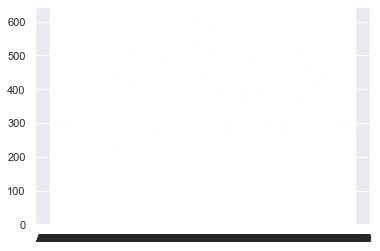

In [91]:
# Bar plot for df2020_2021_r1
plt.bar(df2020_2021_r1.Code, df2020_2021_r1.R1_POINTS)

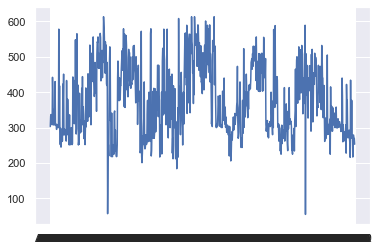

In [92]:
plt.plot(df2020_2021_r1.Code, df2020_2021_r1.R1_POINTS)

## Highest Points Requirements

As the dataset is too large to graph, I chose to focus on the top 10 courses (based off of points) and compared the difference between the points required in 2021 and 2020

We are focusing on the top 10 highest points for the current year 2021 and comparing the same in 2020

In [93]:
# Getting the largest (highest) points from R1 points in 2021
df2020_2021_r1.nlargest(10, 'points_R1_2021')

,Code,Title,points_R1_2021,COURSE_TITLE,R1_POINTS
144,CK702,Dentistry,625.0,Dentistry,613.0
382,TR034,Management Science and Information Systems Stu...,625.0,Management Science and Information Systems Stu...,613.0
390,TR052,Dental Science,625.0,Dental Science,613.0
443,DN670,Economics and Finance,625.0,Economics and Finance,613.0
145,CK703,Pharmacy,613.0,Pharmacy,590.0
198,DC116,Global Business (USA),613.0,Global Business (USA),579.0
272,RC005,Pharmacy,613.0,Pharmacy,579.0
369,TR015,Philosophy Political Science Economics and S...,613.0,"Philosophy, Political Science, Economics and S...",589.0
399,TR072,Pharmacy,613.0,Pharmacy,590.0
400,TR080,Global Business,613.0,Global Business,589.0


In [94]:
# Creating a new dataframe for the largest
df2020_2021_r1_nlargest = df2020_2021_r1.nlargest(10, 'points_R1_2021')

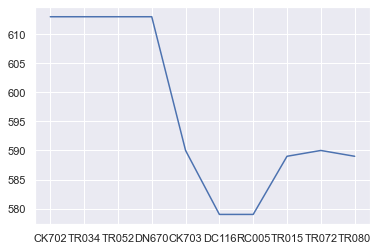

In [95]:
plt.plot(df2020_2021_r1_nlargest.Code, df2020_2021_r1_nlargest.R1_POINTS)

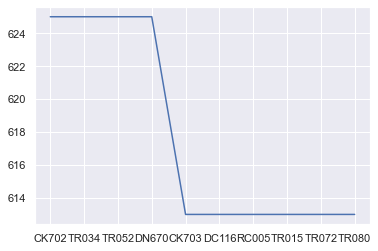

In [96]:
plt.plot(df2020_2021_r1_nlargest.Code, df2020_2021_r1_nlargest.points_R1_2021)

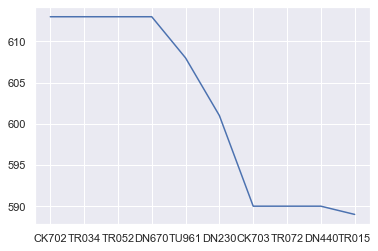

In [97]:
plt.plot(df2020_2021_r1.nlargest(10, 'R1_POINTS').Code, df2020_2021_r1.nlargest(10, 'R1_POINTS').R1_POINTS)

Comparing the unique titles from 2021 and 2020. On analysis it was found there more unique courses in 2020 than in 2021. Courses removed/merged together

## Lowest Points
I also chose to look at the courses that required the lowest points and compared the difference in points between the years 2021 and 2020

In [98]:
# Getting the lowest (smallest) points from R1 points 2021
df2020_2021_r1.nsmallest(10, 'points_R1_2021')

,Code,Title,points_R1_2021,COURSE_TITLE,R1_POINTS
690,LM101,Medicine - Graduate Entry (GAMSAT required),57.0,Medicine - Graduate Entry (GAMSAT required),55.0
155,CK791,Medicine - Graduate Entry (GAMSAT required),60.0,Medicine - Graduate Entry (GAMSAT required),57.0
516,GA887,History and Geography,201.0,History and Geography,244.0
602,MI001,Contemporary and Applied Theatre Studies,209.0,Contemporary & Applied Theatre Studies,375.0
249,DL840,Digital Marketing,210.0,Digital Marketing,228.0
167,DB510,Audio Production and Music Project Management,217.0,Audio Production and Music Project Management,234.0
486,GA380,International Hotel Management,218.0,International Hotel Management,242.0
330,TU919,Advertising and Marketing Communications,219.0,Advertising and Marketing Communications,228.0
244,DL823,Business Management,220.0,Business Management,235.0
260,GC450,Communications and Media Production,225.0,Communications and Media Production,254.0


In [99]:
df2020_2021_r1_nsmallest = df2020_2021_r1.nsmallest(10, 'points_R1_2021')

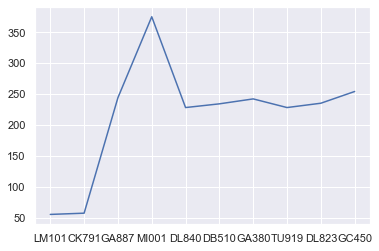

In [100]:
plt.plot(df2020_2021_r1_nsmallest.Code, df2020_2021_r1_nsmallest.R1_POINTS)

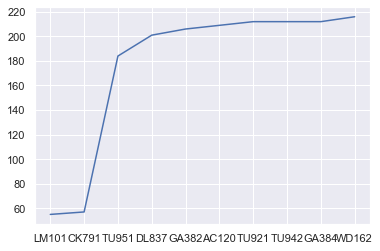

In [101]:
plt.plot(df2020_2021_r1.nsmallest(10, 'R1_POINTS').Code, df2020_2021_r1.nsmallest(10, 'R1_POINTS').R1_POINTS)

As seen from both the highest and lowest points from 2020 and 2021 there has been an increase in the points requirement to gain entry to the courses in 2021

## Comparing 2020 and 2021 Data

### Comparing Highest Courses

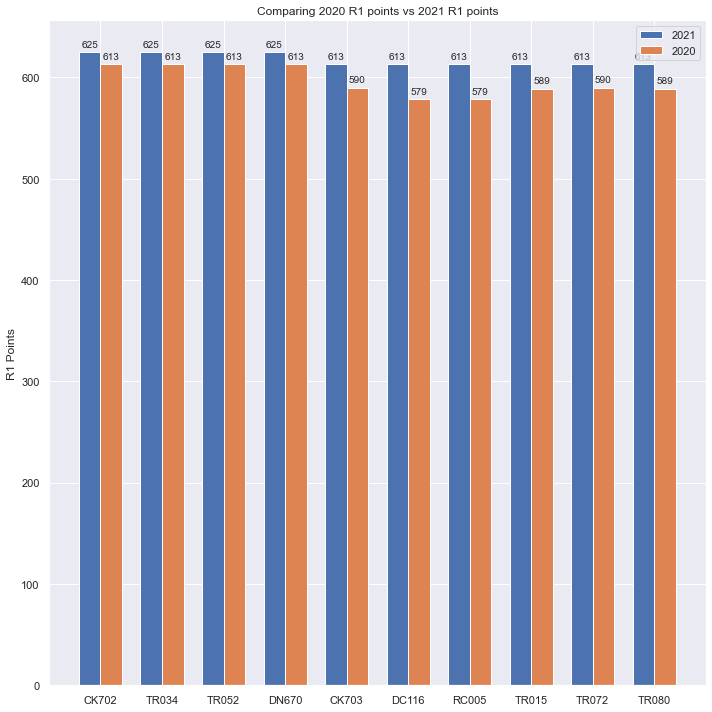

In [102]:
# Creating the dataframe for the largest points in R1 2021
df_nlargest_2020_2021 = df2020_2021_r1.nlargest(10, 'points_R1_2021')

# x is the largest points on Code
x = np.arange(len(df_nlargest_2020_2021.Code))
width = 0.35  # the width of the bars

# Creating the figure dimensions
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# Creating the bar for 2021
rects1 = ax.bar(x - width/2, df_nlargest_2020_2021.points_R1_2021, width, label='2021')
# Creating the bar for 2020
rects2 = ax.bar(x + width/2, df_nlargest_2020_2021.R1_POINTS, width, label='2020')

# Setting the axid label and title
ax.set_ylabel('R1 Points')
ax.set_title('Comparing 2020 R1 points vs 2021 R1 points')
# Setting the ticks on the x axis
ax.set_xticks(x)
ax.set_xticklabels(df_nlargest_2020_2021.Code)
# Adding legend
ax.legend()
# Adding labels
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Comparing Lowest Courses

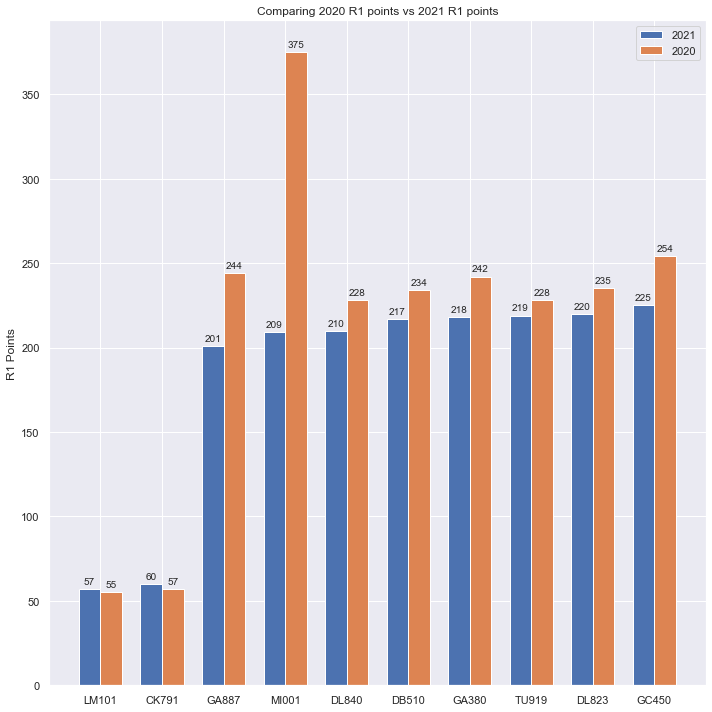

In [103]:
# Creating the dataframe for the smallest points in R1 2021
df_nsmallest_2020_2021 = df2020_2021_r1.nsmallest(10, 'points_R1_2021')

# x is the largest points on Code
x = np.arange(len(df_nsmallest_2020_2021.Code))
width = 0.35  # the width of the bars

# Creating the figure dimensions
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

# Creating the bar for 2021
rects1 = ax.bar(x - width/2, df_nsmallest_2020_2021.points_R1_2021, width, label='2021')
# Creating the bar for 2020
rects2 = ax.bar(x + width/2, df_nsmallest_2020_2021.R1_POINTS, width, label='2020')

# Setting the axid label and title
ax.set_ylabel('R1 Points')
ax.set_title('Comparing 2020 R1 points vs 2021 R1 points')
# Setting the ticks on the x axis
ax.set_xticks(x)
ax.set_xticklabels(df_nsmallest_2020_2021.Code)
# Adding legend
ax.legend()
# Adding labels
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Comparing Difference in Points

In [104]:
df2020_2021_r1.set_index('Code', inplace=True)


In [105]:
diff_21_20 = df2020_2021_r1["points_R1_2021"]-df2020_2021_r1["R1_POINTS"]
diff_21_20

Code
AL801    -3.0
AL802   -19.0
AL803    13.0
AL805   -12.0
AL810     9.0
         ... 
WD195     0.0
WD210   -19.0
WD211    -1.0
WD212    -8.0
WD230   -23.0
Length: 824, dtype: float64

<AxesSubplot:>

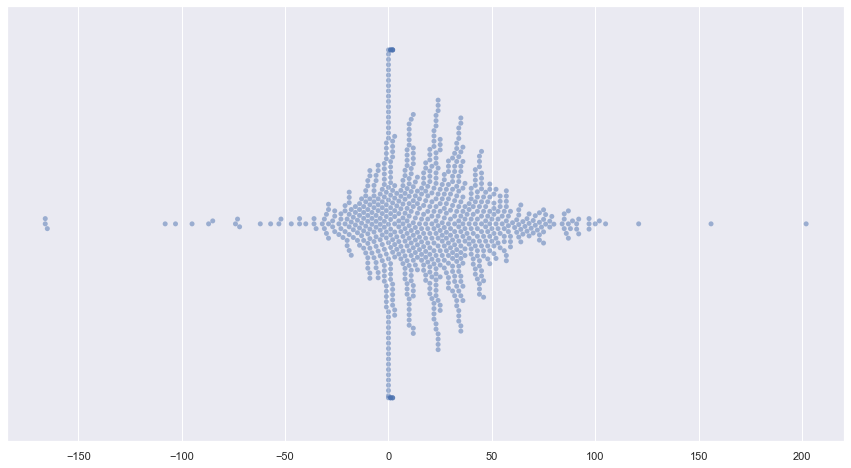

In [106]:
sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.swarmplot(x = diff_21_20,  s = 5, color ="b", alpha=0.5)

# 2019 Data
***

## Overview of 2019

After comapring the years 2020 and 2021 the next section of the data to be examined is the year 2019.
In this section the dataframe df2019 used to examine the data. The dataframe is examined using the commands df.describe and df.info. As these indicated that the data were objects and not floats the data from R1 Points was converted to float. The dataframe was examined to ascertain how prevailant NaN was in the data. It was found that <2% of Mid Points were NaN, therefore these were removed as they made up only a small fraction of the data overall. EOS points were not focused on in this analysis as EOS indicates the points required the year previous. Therefore Mid was chosen for analysis, this is the median points required for entry into a given course. Once it was decided that the EOS Points were to be excluded a new dataframe was created, df2019_r1, containing Code, Title and Mid Points. Upon examining this dataframe using ,max() it was shown the highest course points was 1073, as the highest points that can be achieved in the Leaving Certificate is 625 all courses above 625 were removed. The logic for the removal of these courses is that the points could not be differentiated from the points and the points obtained from either Test/Interview/Portfolio/Audition. 

## Joining the Code and Points 

Joining the codes and titles for each year. This is done by first creating a dataframe containing the code and title for each year, then joining all the years codes and titles together, removing any duplicates. 

In [107]:
courses2019 = df2019[['Code', 'Title']]
courses2019

,Code,Title
0,AL801,Software Design with Virtual Reality and Gaming
1,AL802,Software Design with Cloud Computing
2,AL803,Software Design with Mobile Apps and Connected...
3,AL805,Network Management and Cloud Infrastructure
4,AL810,Quantity Surveying
...,...,...
925,WD200,Arts (options)
926,WD210,Software Systems Development
927,WD211,Creative Computing
928,WD212,Recreation and Sport Management


In [108]:
# Setting index
df2019.set_index('Code', inplace=True)
# Renaming columns
df2019.columns = ['Title','EOS_2019','Mid_2019']
df2019

,Title,EOS_2019,Mid_2019
Code,,,
AL801,Software Design with Virtual Reality and Gaming,304,328
AL802,Software Design with Cloud Computing,301,306
AL803,Software Design with Mobile Apps and Connected...,309,337
AL805,Network Management and Cloud Infrastructure,329,442
AL810,Quantity Surveying,307,349
...,...,...,...
WD200,Arts (options),221,296
WD210,Software Systems Development,271,329
WD211,Creative Computing,275,322


## Examining the 2019 Data

Here I will use df.describe() to get a general description of the dataset, however as this command works on floats it will not describe the objects in the dataset therefore I will also use df.info() for further examination of the dataset. Finally I will look at how many unique points there are in the dataset.

In [109]:
# Describing the dataframe
df2019.describe()

,Title,EOS_2019,Mid_2019
count,930,926,915
unique,719,307,278
top,Accounting and Finance,300,543
freq,11,32,14


In [110]:
# Info on the dataframe
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930 entries, AL801 to WD230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     930 non-null    object
 1   EOS_2019  926 non-null    object
 2   Mid_2019  915 non-null    object
dtypes: object(3)
memory usage: 29.1+ KB


In [112]:
# Length of unique titles
len(df2019.Title.unique())

719

In [113]:
# Checking to see if the titles are the same for 2021 and 2020
# Returns false => not the same
df2019.Title.unique() == df2018['Title'].unique()

/var/folders/51/_5_9h43n1rj7z1sw9wk7030m0000gn/T/ipykernel_97259/1668386546.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  df2019.Title.unique() == df2018['Title'].unique()


False

## Finding Percent of NaN values in Mid and EOS

In [114]:
# Getting % of NaN
df2019.isna().sum().sort_values(ascending = False) / len(df2019)

Mid_2019    0.016129
EOS_2019    0.004301
Title       0.000000
dtype: float64

% of NaN values for Mid <2% therefore dropped NaN Values.

Focused on Mid as this attribute is the median points required for entry into a course whereas EOS is the points that were required the year previous.

## Converting Mid Points to Float

In order to perform analysis on this data it must be converted from object to float.

In [115]:
# Converting object Mid_2019 to float
df2019["Mid_2019"] = pd.to_numeric(df2019["Mid_2019"], downcast="float", errors='coerce')

In [116]:
# Double checking it was converted to float
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930 entries, AL801 to WD230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     930 non-null    object 
 1   EOS_2019  926 non-null    object 
 2   Mid_2019  914 non-null    float32
dtypes: float32(1), object(2)
memory usage: 25.4+ KB


## Creating a Dataframe containing Mid Points

In [117]:
df2019_r1 = df2019[['Title','Mid_2019']]

In [118]:
df2019_r1

,Title,Mid_2019
Code,,
AL801,Software Design with Virtual Reality and Gaming,328.0
AL802,Software Design with Cloud Computing,306.0
AL803,Software Design with Mobile Apps and Connected...,337.0
AL805,Network Management and Cloud Infrastructure,442.0
AL810,Quantity Surveying,349.0
...,...,...
WD200,Arts (options),296.0
WD210,Software Systems Development,329.0
WD211,Creative Computing,322.0


In [119]:
# Removing NaN
df2019_r1=df2019_r1.dropna()

In [120]:
df2019_r1

,Title,Mid_2019
Code,,
AL801,Software Design with Virtual Reality and Gaming,328.0
AL802,Software Design with Cloud Computing,306.0
AL803,Software Design with Mobile Apps and Connected...,337.0
AL805,Network Management and Cloud Infrastructure,442.0
AL810,Quantity Surveying,349.0
...,...,...
WD200,Arts (options),296.0
WD210,Software Systems Development,329.0
WD211,Creative Computing,322.0


## Removing any Courses over 625 Points

In [121]:
# Getting max
df2019_r1.Mid_2019.max()

1073.0

In [122]:
# Removing points above 625
df2019_r1 = df2019_r1.loc[df2019_r1["Mid_2019"]<=625.0]

In [123]:
df2019_r1

,Title,Mid_2019
Code,,
AL801,Software Design with Virtual Reality and Gaming,328.0
AL802,Software Design with Cloud Computing,306.0
AL803,Software Design with Mobile Apps and Connected...,337.0
AL805,Network Management and Cloud Infrastructure,442.0
AL810,Quantity Surveying,349.0
...,...,...
WD200,Arts (options),296.0
WD210,Software Systems Development,329.0
WD211,Creative Computing,322.0


In [124]:
# Double checking above 625 removed
df2019_r1.Mid_2019.max()

625.0

In [125]:
# Getting min
df2019_r1.Mid_2019.min()

57.0

In [126]:
len(list(df2019_r1.index.unique()))

871

In [127]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930 entries, AL801 to WD230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     930 non-null    object 
 1   EOS_2019  926 non-null    object 
 2   Mid_2019  914 non-null    float32
dtypes: float32(1), object(2)
memory usage: 25.4+ KB


In [128]:
# Resetting index
df2019_r1 = df2019_r1.reset_index()

In [129]:
df2019_r1

,Code,Title,Mid_2019
0,AL801,Software Design with Virtual Reality and Gaming,328.0
1,AL802,Software Design with Cloud Computing,306.0
2,AL803,Software Design with Mobile Apps and Connected...,337.0
3,AL805,Network Management and Cloud Infrastructure,442.0
4,AL810,Quantity Surveying,349.0
...,...,...,...
866,WD200,Arts (options),296.0
867,WD210,Software Systems Development,329.0
868,WD211,Creative Computing,322.0
869,WD212,Recreation and Sport Management,311.0


# 2018 Data
***

## Overview of 2018

In this section the data from 2018 was examined using the dataframe df2018. The dataframe is examined using the commands df.describe and df.info. The dataframe was examined to ascertain how prevailant NaN was in the data. It was found that <3% of Mid Points were NaN, therefore these were removed as they made up only a small fraction of the data overall. EOS points were not focused on in this analysis as EOS indicates the points required the year previous. Therefore Mid was chosen for analysis, this is the median points required for entry into a given course. Once it was decided that the EOS Points were to be excluded a new dataframe was created, df2018_r1, containing Code, Title and Mid Points. Upon examining this dataframe using ,max() it was shown the highest course points was 1045, as the highest points that can be achieved in the Leaving Certificate is 625 all courses above 625 were removed. The logic for the removal of these courses is that the points could not be differentiated from the points and the points obtained from either Test/Interview/Portfolio/Audition. 

## Joining the Code and Points 

In [130]:
courses2018 = df2018[['Code', 'Title']]
courses2018

,Code,Title
0,AL801,Software Design (Game Development or Cloud Com...
1,AL810,Quantity Surveying
2,AL820,Mechanical and Polymer Engineering
3,AL830,General Nursing
4,AL832,Psychiatric Nursing
...,...,...
898,WD197,The Internet of Things
899,WD200,Arts
900,WD210,Software Systems Development
901,WD211,Creative Computing


In [131]:
# Setting index
df2018.set_index('Code', inplace=True)
# Renaming columns
df2018.columns = ['Title','EOS_2018','Mid_2018']
df2018

,Title,EOS_2018,Mid_2018
Code,,,
AL801,Software Design (Game Development or Cloud Com...,295,326.0
AL810,Quantity Surveying,300,340.0
AL820,Mechanical and Polymer Engineering,299,371.0
AL830,General Nursing,418,440.0
AL832,Psychiatric Nursing,377,388.0
...,...,...,...
WD197,The Internet of Things,260,329.0
WD200,Arts,220,299.0
WD210,Software Systems Development,289,327.0


## Examining the 2018 Data

Here I will use df.describe() to get a general description of the dataset, however as this command works on floats it will not describe the objects in the dataset therefore I will also use df.info() for further examination of the dataset. Finally I will look at how many unique points there are in the dataset.

In [132]:
# Describing the dataframe
df2018.describe()

,Mid_2018
count,875.000000
mean,422.273143
std,127.488725
min,56.000000
25%,338.000000
50%,392.000000
75%,476.000000
max,1045.000000


In [133]:
# Info on dataframe
df2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903 entries, AL801  to WD212 
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     903 non-null    object 
 1   EOS_2018  891 non-null    object 
 2   Mid_2018  875 non-null    float64
dtypes: float64(1), object(2)
memory usage: 28.2+ KB


## Creating a Dataframe containing Mid Points

In [134]:
df2018_r1 = df2018[['Title','Mid_2018']]

In [135]:
df2018_r1

,Title,Mid_2018
Code,,
AL801,Software Design (Game Development or Cloud Com...,326.0
AL810,Quantity Surveying,340.0
AL820,Mechanical and Polymer Engineering,371.0
AL830,General Nursing,440.0
AL832,Psychiatric Nursing,388.0
...,...,...
WD197,The Internet of Things,329.0
WD200,Arts,299.0
WD210,Software Systems Development,327.0


## Finding Percent of NaN values in Mid and EOS

In [136]:
# Finding % of NaN
df2018.isna().sum().sort_values(ascending = False) / len(df2018)

Mid_2018    0.031008
EOS_2018    0.013289
Title       0.000000
dtype: float64

% of NaN values for Mid <3% therefore dropped NaN Values.

Focused on Mid as this attribute is the median points required for entry into a course whereas EOS is the points that were required the year previous.

In [137]:
# Removing NaN
df2018_r1=df2018_r1.dropna()

In [138]:
df2018_r1

,Title,Mid_2018
Code,,
AL801,Software Design (Game Development or Cloud Com...,326.0
AL810,Quantity Surveying,340.0
AL820,Mechanical and Polymer Engineering,371.0
AL830,General Nursing,440.0
AL832,Psychiatric Nursing,388.0
...,...,...
WD197,The Internet of Things,329.0
WD200,Arts,299.0
WD210,Software Systems Development,327.0


## Min and Max Points

In [139]:
# Getting max
df2018_r1.Mid_2018.max()

1045.0

In [140]:
# Getting min
df2018_r1.Mid_2018.min()

56.0

In [141]:
# Resetting index
df2018_r1 = df2018_r1.reset_index()

In [142]:
df2018_r1

,Code,Title,Mid_2018
0,AL801,Software Design (Game Development or Cloud Com...,326.0
1,AL810,Quantity Surveying,340.0
2,AL820,Mechanical and Polymer Engineering,371.0
3,AL830,General Nursing,440.0
4,AL832,Psychiatric Nursing,388.0
...,...,...,...
870,WD197,The Internet of Things,329.0
871,WD200,Arts,299.0
872,WD210,Software Systems Development,327.0
873,WD211,Creative Computing,326.0


## Removing any Courses over 625 Points

In [143]:
# Removing over 625
df2018_r1 = df2018_r1.loc[df2018_r1["Mid_2018"]<=625.0]

In [144]:
# Double checking
df2018_r1.Mid_2018.max()

603.0

In [145]:
df2018_r1.Mid_2018.min()

56.0

# 2017 Data
***

## Overview of 2017

In this section the data from 2017 was examined using the dataframe df2017. The dataframe is examined using the commands df.describe and df.info. The dataframe was examined to ascertain how prevailant NaN was in the data. It was found that <2% of Mid Points were NaN, therefore these were removed as they made up only a small fraction of the data overall. EOS points were not focused on in this analysis as EOS indicates the points required the year previous. Therefore Mid was chosen for analysis, this is the median points required for entry into a given course. Once it was decided that the EOS Points were to be excluded a new dataframe was created, df2018_r1, containing Code, Title and Mid Points. Upon examining this dataframe using ,max() it was shown the highest course points was 1068, as the highest points that can be achieved in the Leaving Certificate is 625 all courses above 625 were removed. The logic for the removal of these courses is that the points could not be differentiated from the points and the points obtained from either Test/Interview/Portfolio/Audition. 

## Joining the Code and Points 

In [146]:
courses2017 = df2017[['Code', 'Title']]
courses2017

,Code,Title
0,AL801,Software Design (Game Development or Cloud Com...
1,AL810,Quantity Surveying
2,AL820,Mechanical and Polymer Engineering
3,AL830,General Nursing
4,AL832,Psychiatric Nursing
...,...,...
860,WD193,Marketing and Digital Media
861,WD194,Culinary Arts
862,WD195,Architectural & Building Information Modelling...
863,WD197,The Internet of Things


In [147]:
# Setting index
df2017.set_index('Code', inplace=True)
# Renaming columns
df2017.columns = ['Title','EOS_2017','Mid_2017']
df2017

,Title,EOS_2017,Mid_2017
Code,,,
AL801,Software Design (Game Development or Cloud Com...,290,329.0
AL810,Quantity Surveying,311,357.0
AL820,Mechanical and Polymer Engineering,300,336.0
AL830,General Nursing,398,418.0
AL832,Psychiatric Nursing,378,389.0
...,...,...,...
WD193,Marketing and Digital Media,297,337.0
WD194,Culinary Arts,279,356.0
WD195,Architectural & Building Information Modelling...,273,320.0


## Examining the 2018 Data

Here I will use df.describe() to get a general description of the dataset, however as this command works on floats it will not describe the objects in the dataset therefore I will also use df.info() for further examination of the dataset. Finally I will look at how many unique points there are in the dataset.

In [148]:
# Describing dataframe
df2017.describe()

,Mid_2017
count,847.000000
mean,425.227863
std,128.648223
min,57.000000
25%,339.000000
50%,399.000000
75%,478.000000
max,1068.000000


In [149]:
# Info on dataframe
df2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, AL801  to WD200 
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     865 non-null    object 
 1   EOS_2017  855 non-null    object 
 2   Mid_2017  847 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.0+ KB


## Creating a Dataframe containing Mid Points

In [150]:
df2017_r1 = df2017[['Title','Mid_2017']]

In [151]:
df2017_r1

,Title,Mid_2017
Code,,
AL801,Software Design (Game Development or Cloud Com...,329.0
AL810,Quantity Surveying,357.0
AL820,Mechanical and Polymer Engineering,336.0
AL830,General Nursing,418.0
AL832,Psychiatric Nursing,389.0
...,...,...
WD193,Marketing and Digital Media,337.0
WD194,Culinary Arts,356.0
WD195,Architectural & Building Information Modelling...,320.0


## Finding Percent of NaN values in Mid and EOS

In [152]:
# Getting % of NaN
df2017.isna().sum().sort_values(ascending = False) / len(df2017)

Mid_2017    0.020809
EOS_2017    0.011561
Title       0.000000
dtype: float64

% of NaN values for Mid <2% therefore dropped NaN Values.

Focused on Mid as this attribute is the median points required for entry into a course whereas EOS is the points that were required the year previous.

In [153]:
# Dropping NaN
df2017_r1=df2017_r1.dropna()

In [154]:
df2017_r1

,Title,Mid_2017
Code,,
AL801,Software Design (Game Development or Cloud Com...,329.0
AL810,Quantity Surveying,357.0
AL820,Mechanical and Polymer Engineering,336.0
AL830,General Nursing,418.0
AL832,Psychiatric Nursing,389.0
...,...,...
WD193,Marketing and Digital Media,337.0
WD194,Culinary Arts,356.0
WD195,Architectural & Building Information Modelling...,320.0


## Min and Max Points

In [155]:
# Getting the max
df2017_r1.Mid_2017.max()

1068.0

In [156]:
# Getting the min
df2017_r1.Mid_2017.min()

57.0

## Removing any Courses over 625 Points

In [157]:
# Removing >625
df2017_r1 = df2017_r1.loc[df2017_r1["Mid_2017"]<=625.0]

In [158]:
# Resetting the index
df2017_r1 = df2017_r1.reset_index()

In [159]:
df2017_r1

,Code,Title,Mid_2017
0,AL801,Software Design (Game Development or Cloud Com...,329.0
1,AL810,Quantity Surveying,357.0
2,AL820,Mechanical and Polymer Engineering,336.0
3,AL830,General Nursing,418.0
4,AL832,Psychiatric Nursing,389.0
...,...,...,...
803,WD193,Marketing and Digital Media,337.0
804,WD194,Culinary Arts,356.0
805,WD195,Architectural & Building Information Modelling...,320.0
806,WD197,The Internet of Things,328.0


# 2019, 2018 and 2017 Data
***

## Overview of 2019, 2018 and 2017 Data

As previoulsy stated the data are not synonomous across all years examined in this notebook the years 2019, 2018 and 2017 are grouped together, as they all contain Mid Points.
In order to merge three dataframes first I created a new dataframe containing 2017 and 2018, which I then merged with the data from 2019 creating df2017_2018_2019_r1. It was dicovered when I attempted to merge the dataframes for each year togther that the years 2017 and 2018 contained spaces in the Code, therefore these were stripped from the data in order to merge the years.
Again I focused on the courses with the highest and lowest points, based off of 2019's data. I did this using .nlargest and .nsmallest.
From the bar charts it is clear that for the 10 highest courses on offer the points for each course increased in points from 2018 to 2019. The 10 lowest courses on offer overall decreased in points from 2017 to 2019 with the exception of four lowest courses which only showed either a slight decrease of remained the same as the points required for 2017. 

## Merging 2019, 2018 and 2017 Data

I used pd.merge to merge the Mid points on code for 2019, 2018 and 2017.

As you can only merge two datasets at once I created a new dataframe containing the merged data from 2018 and 2017. Then I merged the newly created dataframe with 2019.

In [160]:
# Merging the 2018 and 2017 data
df2017_2018_r1=pd.merge(df2018_r1, df2017_r1, how='inner', on=['Code'])

In [161]:
df2017_2018_r1

,Code,Title_x,Mid_2018,Title_y,Mid_2017
0,AL801,Software Design (Game Development or Cloud Com...,326.0,Software Design (Game Development or Cloud Com...,329.0
1,AL810,Quantity Surveying,340.0,Quantity Surveying,357.0
2,AL820,Mechanical and Polymer Engineering,371.0,Mechanical and Polymer Engineering,336.0
3,AL830,General Nursing,440.0,General Nursing,418.0
4,AL832,Psychiatric Nursing,388.0,Psychiatric Nursing,389.0
...,...,...,...,...,...
760,WD193,Marketing and Digital Media,348.0,Marketing and Digital Media,337.0
761,WD194,Culinary Arts,320.0,Culinary Arts,356.0
762,WD195,Architectural and Building Information Modelli...,360.0,Architectural & Building Information Modelling...,320.0
763,WD197,The Internet of Things,329.0,The Internet of Things,328.0


In [162]:
# Merging 2018/2017 dataframe to 2019 data
df2017_2018_2019_r1 =pd.merge(df2017_2018_r1, df2019_r1, how='inner', on=['Code'])

In [163]:
# Displaying the data (no data appears)
df2017_2018_2019_r1

,Code,Title_x,Mid_2018,Title_y,Mid_2017,Title,Mid_2019


In [164]:
# Getting info on df2019_r1
df2019_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Code      871 non-null    object 
 1   Title     871 non-null    object 
 2   Mid_2019  871 non-null    float32
dtypes: float32(1), object(2)
memory usage: 17.1+ KB


In [165]:
# Getting info on df2017_2018_r1
df2017_2018_r1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765 entries, 0 to 764
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Code      765 non-null    object 
 1   Title_x   765 non-null    object 
 2   Mid_2018  765 non-null    float64
 3   Title_y   765 non-null    object 
 4   Mid_2017  765 non-null    float64
dtypes: float64(2), object(3)
memory usage: 35.9+ KB


In 2018 and 2017 the code field had trailing spaces which was different from 2019, therefore we were required to strip off the trailing spaces from the "Code" feature for the year 2018 and 2017 to facilitate comparison and analysis with that of 2019

In [166]:
# Removing trailing spaces from 2017
df2017_r1.Code=df2017_r1.Code.str.strip()

In [167]:
# Removing trailing spaces from 2018
df2018_r1.Code=df2018_r1.Code.str.strip()

/Users/saidhbhfoley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [168]:
# merging the 2018 and 2017 data with the spaces removed
df2018_2017_r1=pd.merge(df2017_r1, df2018_r1, how='inner', on=['Code'])

In [169]:
# merging all years of data
df2019_2018_2017_r1=pd.merge(df2018_2017_r1, df2019_r1, how='inner', on=['Code'])

In [170]:
# Displaying the data
df2019_2018_2017_r1

,Code,Title_x,Mid_2017,Title_y,Mid_2018,Title,Mid_2019
0,AL801,Software Design (Game Development or Cloud Com...,329.0,Software Design (Game Development or Cloud Com...,326.0,Software Design with Virtual Reality and Gaming,328.0
1,AL810,Quantity Surveying,357.0,Quantity Surveying,340.0,Quantity Surveying,349.0
2,AL820,Mechanical and Polymer Engineering,336.0,Mechanical and Polymer Engineering,371.0,Mechanical and Polymer Engineering,358.0
3,AL830,General Nursing,418.0,General Nursing,440.0,General Nursing,429.0
4,AL832,Psychiatric Nursing,389.0,Psychiatric Nursing,388.0,Psychiatric Nursing,403.0
...,...,...,...,...,...,...,...
705,WD192,Social Care Practice,310.0,Social Care Practice,319.0,Social Care Practice,323.0
706,WD193,Marketing and Digital Media,337.0,Marketing and Digital Media,348.0,Marketing and Digital Media,358.0
707,WD194,Culinary Arts,356.0,Culinary Arts,320.0,Culinary Arts,331.0
708,WD195,Architectural & Building Information Modelling...,320.0,Architectural and Building Information Modelli...,360.0,Architectural and Building Information Modelli...,305.0


## Top 10 Courses

In [171]:
# highest points in the data based off Mid_2019
df2019_2018_2017_r1.nlargest(10, 'Mid_2019')

,Code,Title_x,Mid_2017,Title_y,Mid_2018,Title,Mid_2019
479,GY261,Business Studies (Interview - International Ho...,580.0,Business Studies (International Hotel Manageme...,603.0,Business Studies (International Hotel Manageme...,615.0
91,CK702,Dentistry,589.0,Dentistry,590.0,Dentistry,613.0
338,TR034,Management Science and Information Systems Stu...,589.0,Management Science and Information Systems Stu...,589.0,Management Science and Information Systems Stu...,602.0
343,TR052,Dental Science,601.0,Dental Science,601.0,Dental Science,602.0
339,TR035,Theoretical Physics,590.0,Theoretical Physics,577.0,Theoretical Physics,601.0
395,DN670,Quantitative Business - Economics and Finance,601.0,Economics and Finance,601.0,Economics and Finance,601.0
327,TR020,Law and Political Science,601.0,Law and Political Science,595.0,Law and Political Science,600.0
133,DC014,Jazz and Contemporary Music Performance (Audit...,413.0,BA in Jazz and Contemporary Music Performance ...,389.0,BA in Jazz and Contemporary Music Performance,590.0
92,CK703,Pharmacy,578.0,Pharmacy,567.0,Pharmacy,589.0
140,DC116,Global Business (USA),578.0,Global Business (USA),589.0,Global Business (USA),589.0


In [172]:
df2019_2018_2017_r1_nlargest = df2019_2018_2017_r1.nlargest(10, 'Mid_2019')

## Lowest 10 Courses

In [173]:
# lowest points in the data based off Mid_2019
df2019_2018_2017_r1.nsmallest(10, 'Mid_2019')

,Code,Title_x,Mid_2017,Title_y,Mid_2018,Title,Mid_2019
585,LM101,Medicine (Graduate Entry),57.0,Medicine (Graduate Entry),56.0,Medicine - Graduate Entry (GAMSAT required),57.0
101,CK791,Medicine (Graduate Entry),59.0,Medicine (Graduate Entry),58.0,Medicine Graduate Entry (GAMSAT required),59.0
380,DN401,Medicine - Graduate Entry,62.0,Medicine - Graduate Entry,62.0,Medicine - Graduate Entry (GAMSAT required),61.0
313,RC101,Medicine - Graduate Entry,60.0,Medicine - Graduate Entry,61.0,Medicine - Graduate Entry (GAMSAT required),62.0
102,AC120,International Business,347.0,International Business,288.0,International Business,269.0
267,GC430,Computing Science (Dublin),304.0,Computing Science (Dublin),339.0,Computing Science (Dublin),269.0
289,TA026,International Hospitality and Tourism Management,279.0,International Hospitality and Tourism Management,291.0,International Hospitality and Tourism Management,269.0
552,LC297,Community Development,297.0,Community Development,281.0,Community Development,269.0
117,DB521,Accounting and Finance,305.0,Accounting and Finance,295.0,Accounting and Finance,271.0
607,MH116,Community and Youth Work (Full-Time),309.0,Community and Youth Work (Full-Time),299.0,Community and Youth Work (Full-Time),271.0


## Plotting the Data

In [174]:
df2019_2018_2017_r1_nsmallest = df2019_2018_2017_r1.nsmallest(10, 'Mid_2019')

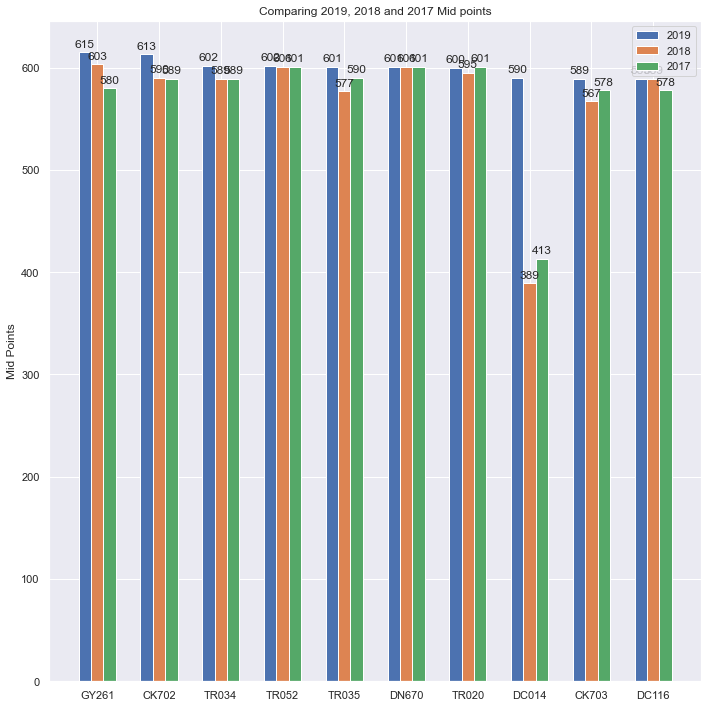

In [175]:
df2019_2018_2017_r1_nlargest = df2019_2018_2017_r1.nlargest(10, 'Mid_2019')
x = np.arange(len(df2019_2018_2017_r1_nlargest.Code))
width = 0.2  # the width of the bars

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

rects1 = ax.bar(x - width, df2019_2018_2017_r1_nlargest.Mid_2019, width, label='2019')
rects2 = ax.bar(x, df2019_2018_2017_r1_nlargest.Mid_2018, width, label='2018')
rects3 = ax.bar(x + width, df2019_2018_2017_r1_nlargest.Mid_2017, width, label='2017')

ax.set_ylabel('Mid Points')
ax.set_title('Comparing 2019, 2018 and 2017 Mid points')
ax.set_xticks(x)
ax.set_xticklabels(df2019_2018_2017_r1_nlargest.Code)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

Showing trends for top 10 mid points from 2019, 2018 and 2017. There is an overall trend for these courses increasing in points between the years 2018 and 2019, for example: GY261 Business Studies (NUIG) has increased in points each year in 2017 it required a minimum of 580, rising to 603 in 2018 and 615 in 2019. Only two courses did not have an increase in points in 2019 compared with 2018 DN670 and DC116. The course that had the largest increase over the three years was DC014 which increased from 413 points in 2017 to 590 in 2019. However as I choose to focus on the highest points for 2019 this may explain why there is not exaggerrated jumps for other courses as the other courses do not have a large increase. The points for these courses were always high and remain high.

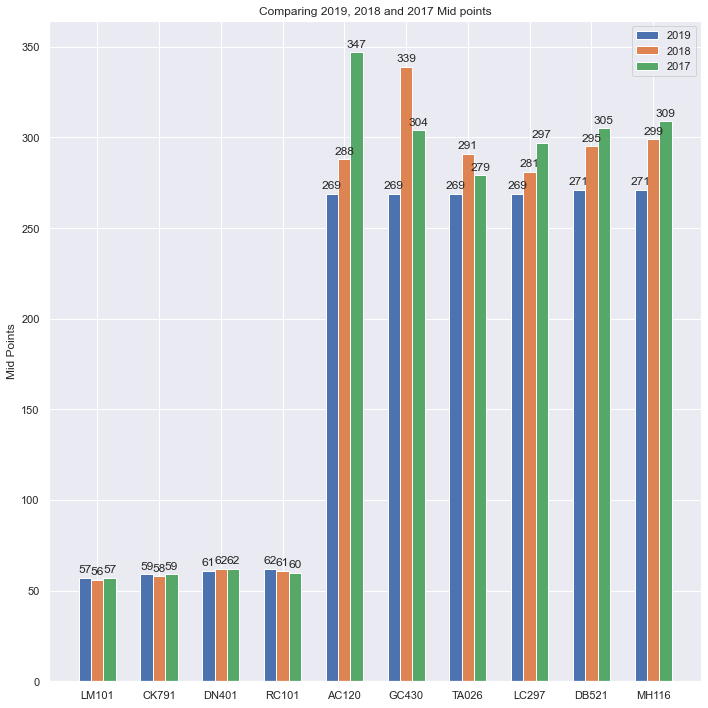

In [176]:
df2019_2018_2017_r1_nsmallest = df2019_2018_2017_r1.nsmallest(10, 'Mid_2019')
x = np.arange(len(df2019_2018_2017_r1_nsmallest.Code))
width = 0.2  # the width of the bars

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

rects1 = ax.bar(x - width, df2019_2018_2017_r1_nsmallest.Mid_2019, width, label='2019')
rects2 = ax.bar(x, df2019_2018_2017_r1_nsmallest.Mid_2018, width, label='2018')
rects3 = ax.bar(x + width, df2019_2018_2017_r1_nsmallest.Mid_2017, width, label='2017')

ax.set_ylabel('Mid Points')
ax.set_title('Comparing 2019, 2018 and 2017 Mid points')
ax.set_xticks(x)
ax.set_xticklabels(df2019_2018_2017_r1_nsmallest.Code)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

Showing trends for lowest 10 course mid points from 2019, 2018 and 2017. There is an overall trend for these courses decreasing in points between the years 2017, 2018 and 2019, for example: AC120 has decreased in points each year in 2017 it required a minimum of 347 points, decreasing to 288 in 2018 and 269 in 2019. The four lowest courses offered from the CAO all remained stable points wise. The remaining six courses all saw a decline in points from 2017 to 2019.

### Difference in Points 2019 and 2018

In [177]:
diff_19_18 = df2019_2018_2017_r1["Mid_2019"]-df2019_2018_2017_r1["Mid_2018"]
diff_19_18

0       2.0
1       9.0
2     -13.0
3     -11.0
4      15.0
       ... 
705     4.0
706    10.0
707    11.0
708   -55.0
709    -3.0
Length: 710, dtype: float64

<AxesSubplot:>

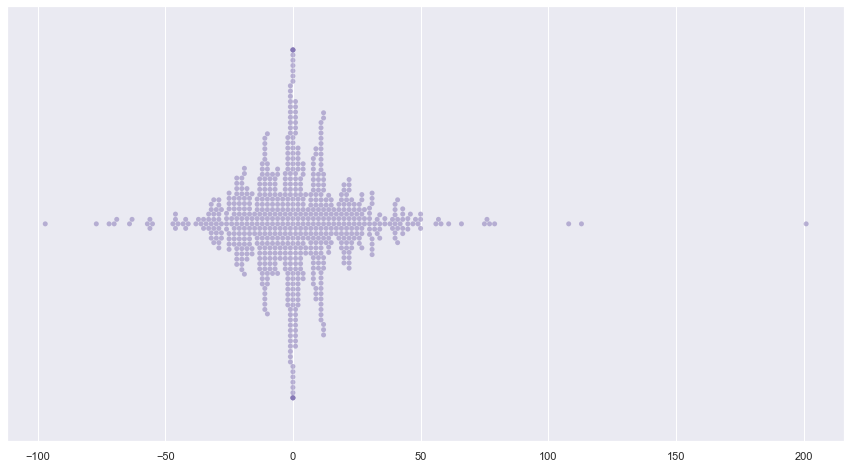

In [178]:
sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.swarmplot(x = diff_19_18,  s = 5, color ="m", alpha=0.5)

### Difference in Points 2018 and 2017

In [179]:
df2017_2018_r1.set_index('Code', inplace=True)

In [180]:
diff_18_17 = df2017_2018_r1["Mid_2018"]-df2017_2018_r1["Mid_2017"]
diff_18_17

Code
AL801     -3.0
AL810    -17.0
AL820     35.0
AL830     22.0
AL832     -1.0
          ... 
WD193     11.0
WD194    -36.0
WD195     40.0
WD197      1.0
WD200    -10.0
Length: 765, dtype: float64

<AxesSubplot:>

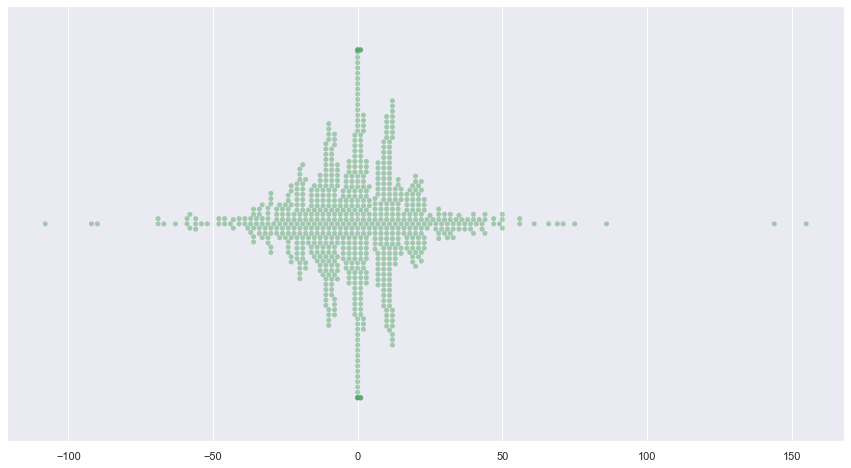

In [181]:
sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.swarmplot(x = diff_18_17,  s = 5, color ="g", alpha=0.5)

### Difference in Points 2019 and 2017

In [182]:
df2019_2018_2017_r1.set_index('Code', inplace=True)

In [183]:
diff_19_17 = df2019_2018_2017_r1["Mid_2019"]-df2019_2018_2017_r1["Mid_2017"]
diff_19_17

Code
AL801    -1.0
AL810    -8.0
AL820    22.0
AL830    11.0
AL832    14.0
         ... 
WD192    13.0
WD193    21.0
WD194   -25.0
WD195   -15.0
WD200   -13.0
Length: 710, dtype: float64

<AxesSubplot:>

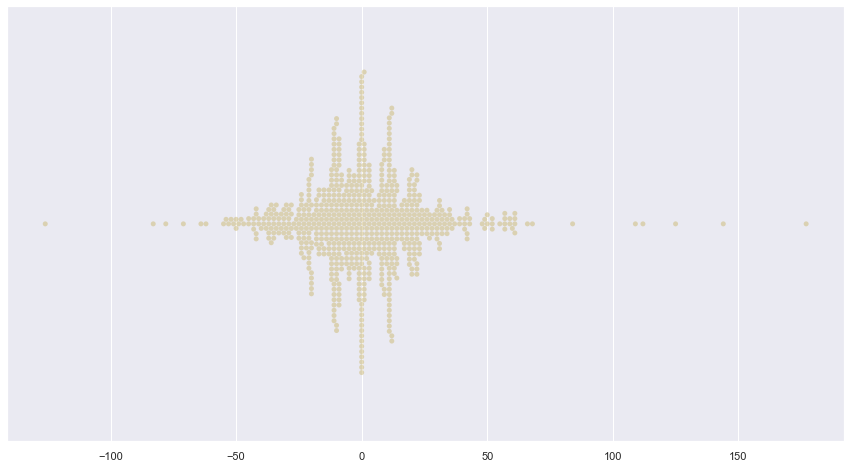

In [184]:
sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.swarmplot(x = diff_19_17,  s = 5, color ="y", alpha=0.5)

# Top Universities
***

I choose to examine the point requirements for the top five universities in Ireland<sup>6</sup>:

   1. Trinity College Dublin
   2. University College Dublin
   3. National Univeristy of Ireland Galway
   4. Univeristy College Cork
   5. Dublin City University
    
I looked at the 10 most in demand courses for these universities from 2021 to 2017, to examine if there was trend in the popularity of courses offered by these universities over the years. As I was not extrapolating data from the points but observing the most in demand courses I did not group the years as previously done but instead focused on all years in this section. 
For Trinity College Dublin only 2 courses appeared in the top 10 courses each year but 6 courses appeared in 4 out of 5 years.
For UCD 7 courses appeared in the top 10 courses each year and only 1 course appeared in 4 out of 5 years.
For NUIG only 3 courses appeared in the top 10 courses each year with 2 courses appearing in 4 out of 5 years.
FOR UCC 6 courses appeared in the top 10 courses each year and only 1 course appeared in 4 out of 5 years.
For DCU 5 courses appeared in the top 10 courses each year with 2 courses appearing in 4 out of 5 years.

In [185]:
# Resetting the index so I can use the function university_distribution below
df2021_r1=df2021_r1.reset_index()

## How many courses were offered by each university

### Number of Courses Offered in 2021

In [186]:
len(df2021_r1[df2021_r1['Code'].str.contains("TR")])

53

In 2021 TCD offered 53 courses to applicants, as this is too large to analyse in detail the 10 most in demand courses in TCD were looked into for 2021.

In [187]:
len(df2021_r1[df2021_r1['Code'].str.contains("DN")])

35

In 2021 UCD offered 35 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [188]:
len(df2021_r1[df2021_r1['Code'].str.contains("GY")])

64

In 2021 NUIG offered 64 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [189]:
len(df2021_r1[df2021_r1['Code'].str.contains("CK")])

61

In 2021 UCC offered 61 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [190]:
len(df2021_r1[df2021_r1['Code'].str.contains("DC")])

68

In 2021 DCU offered 68 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

### Number of Courses Offered in 2020

In [191]:
len(df2020_r1[df2020_r1['Code'].str.contains("TR")])

127

In 2020 TCD offered 127 courses to applicants, as this is too large to analyse in detail the 10 most in demand courses in TCD were looked into for 2020.

In [192]:
len(df2020_r1[df2020_r1['Code'].str.contains("DN")])

38

In 2020 UCD offered 38 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [193]:
len(df2020_r1[df2020_r1['Code'].str.contains("GY")])

68

In 2020 NUIG offered 68 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [194]:
len(df2020_r1[df2020_r1['Code'].str.contains("CK")])

61

In 2020 UCC offered 61 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [195]:
len(df2020_r1[df2020_r1['Code'].str.contains("DC")])

63

In 2020 DCU offered 63 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

### Number of Courses Offered in 2019

In [196]:
len(df2019_r1[df2019_r1['Code'].str.contains("TR")])

56

In 2019 TCD offered 56 courses to applicants, as this is too large to analyse in detail the 10 most in demand courses in TCD were looked into for 2019.

In [197]:
len(df2019_r1[df2019_r1['Code'].str.contains("DN")])

38

In 2019 UCD offered 38 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [198]:
len(df2019_r1[df2019_r1['Code'].str.contains("GY")])

64

In 2019 NUIG offered 64 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [199]:
len(df2019_r1[df2019_r1['Code'].str.contains("CK")])

59

In 2019 UCC offered 59 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [200]:
len(df2019_r1[df2019_r1['Code'].str.contains("DC")])

64

In 2019 DCU offered 64 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

### Number of Courses Offered in 2018

In [201]:
len(df2018_r1[df2018_r1['Code'].str.contains("TR")])

56

In 2018 TCD offered 56 courses to applicants, as this is too large to analyse in detail the 10 most in demand courses in TCD were looked into for 2018.

In [202]:
len(df2018_r1[df2018_r1['Code'].str.contains("DN")])

38

In 2018 UCD offered 38 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [203]:
len(df2018_r1[df2018_r1['Code'].str.contains("GY")])

61

In 2018 NUIG offered 61 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [204]:
len(df2018_r1[df2018_r1['Code'].str.contains("CK")])

58

In 2018 UCC offered 58 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [205]:
len(df2018_r1[df2018_r1['Code'].str.contains("DC")])

64

In 2018 DCU offered 64 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

### Number of Courses Offered in 2017

In [206]:
len(df2017_r1[df2017_r1['Code'].str.contains("TR")])

59

In 2017 TCD offered 59 courses to applicants, as this is too large to analyse in detail the 10 most in demand courses in TCD were looked into for 2017.

In [207]:
len(df2017_r1[df2017_r1['Code'].str.contains("DN")])

39

In 2017 UCD offered 39 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [208]:
len(df2017_r1[df2017_r1['Code'].str.contains("GY")])

54

In 2017 NUIG offered 54 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [209]:
len(df2017_r1[df2017_r1['Code'].str.contains("CK")])

55

In 2017 UCC offered 55 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

In [210]:
len(df2017_r1[df2017_r1['Code'].str.contains("DC")])

63

In 2017 DCU offered 63 courses to applicants, to align with the data from trinity only the 10 most in demand courses will be looked at.

***Number of Courses Offered***

|  | 2021 | 2020 | 2019 | 2018 | 2017 |
| -- | -- | -- | -- | -- | -- |
| TCD | 53 | 127 | 56 | 56 | 57 |
| UCD | 35 | 38 | 38 | 38 | 39 |
| NUIG | 64 | 68 | 64 | 61 | 54 |
| UCC | 61 | 61 | 59 | 58 | 55 |
| DCU | 68 | 63 | 64 | 64 | 63 |




## Creating a function

In order to reproduce the same pie chart for each of the top 5 universities for the years 2021 to 2017 inclusive, I have created the function below.

In [211]:
def university_distribution(data_cao, cao_points, uni_initials):
    df_uni = data_cao[data_cao['Code'].str.contains(uni_initials)]
    df_uni.nlargest(10, cao_points).value_counts().plot.pie(figsize=(5, 5))


## Top Courses Displayed 2021

1. Trinity College Dublin

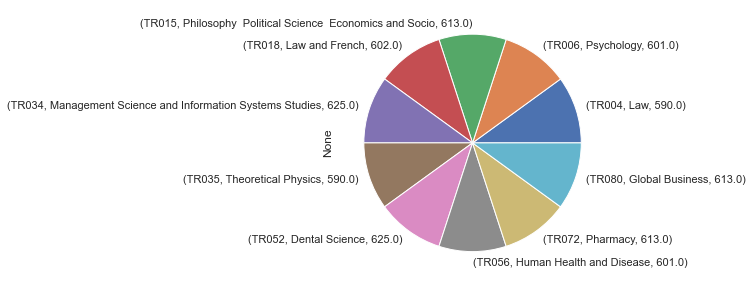

In [212]:
university_distribution(df2021_r1, 'points_R1_2021', 'TR')

2. UCD

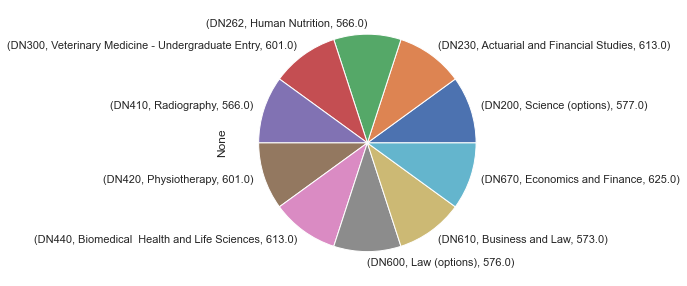

In [213]:
university_distribution(df2021_r1, 'points_R1_2021', 'DN')

3. NUIG

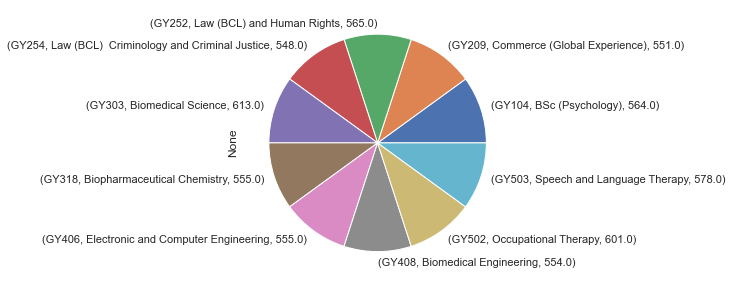

In [214]:
university_distribution(df2021_r1, 'points_R1_2021', 'GY')

4. UCC

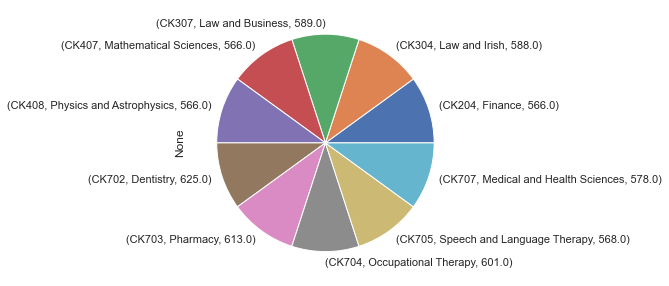

In [215]:
university_distribution(df2021_r1, 'points_R1_2021', 'CK')

5. DCU

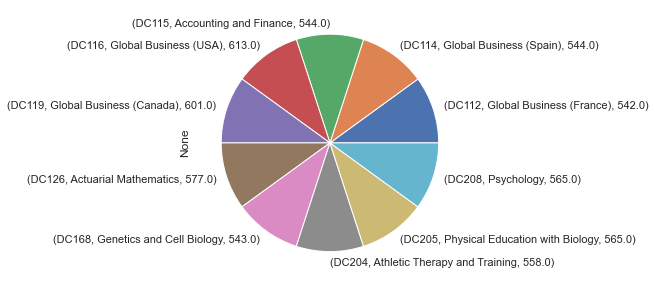

In [216]:
university_distribution(df2021_r1, 'points_R1_2021', 'DC')

## Top Courses Displayed 2020

1. Trinity College Dublin

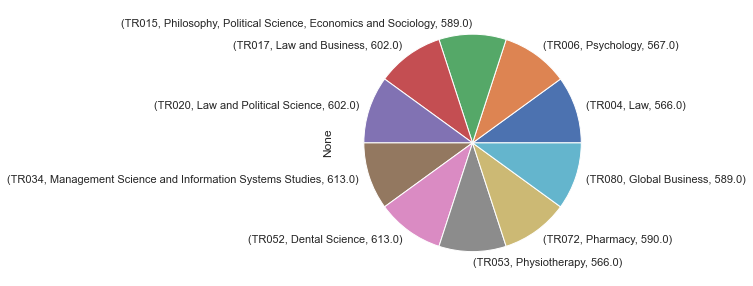

In [217]:
university_distribution(df2020_r1, 'R1_POINTS', 'TR')

2. UCD

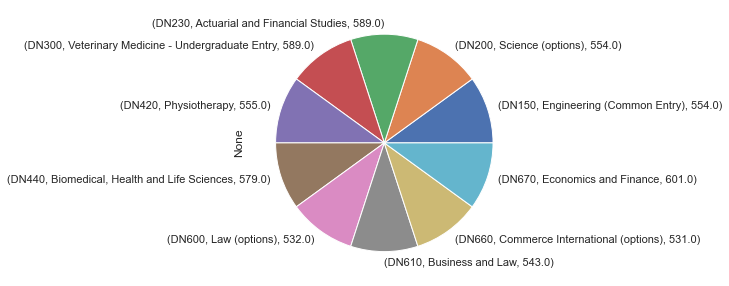

In [218]:
university_distribution(df2019_r1, 'Mid_2019', 'DN')

3. NUIG 

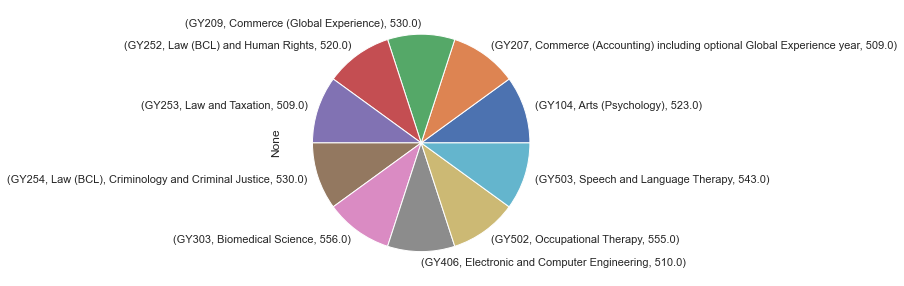

In [219]:
university_distribution(df2020_r1, 'R1_POINTS', 'GY')

4. UCC

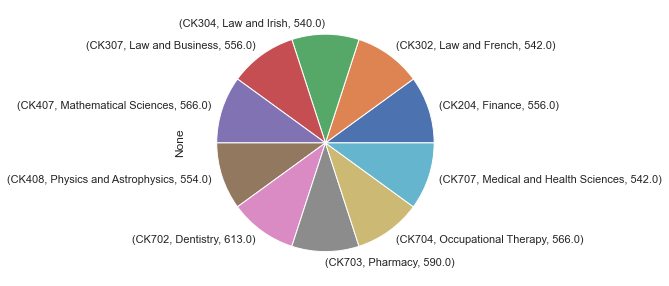

In [220]:
university_distribution(df2020_r1, 'R1_POINTS', 'CK')

5. DCU

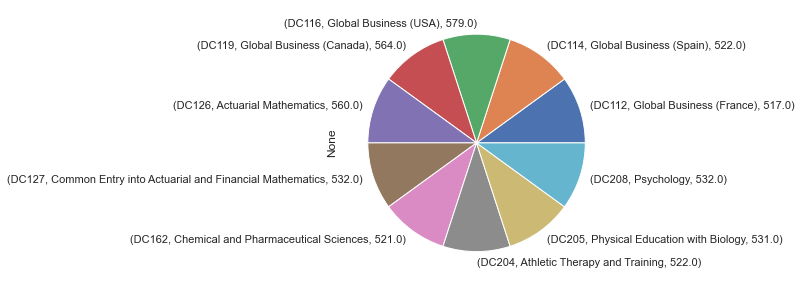

In [221]:
university_distribution(df2020_r1, 'R1_POINTS', 'DC')

## Top Courses Displayed 2019

1. Trinity College Dublin

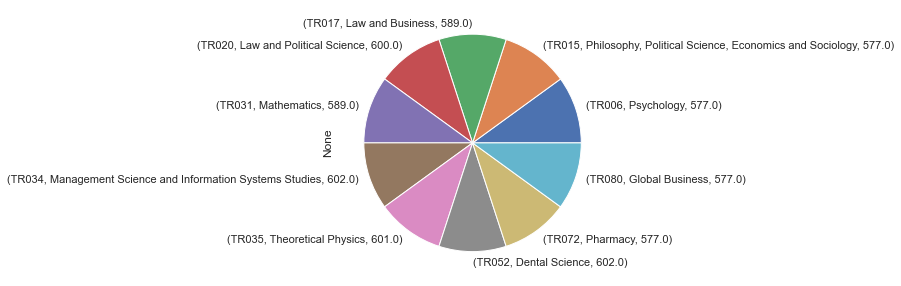

In [222]:
university_distribution(df2019_r1, 'Mid_2019', 'TR')

2. UCD

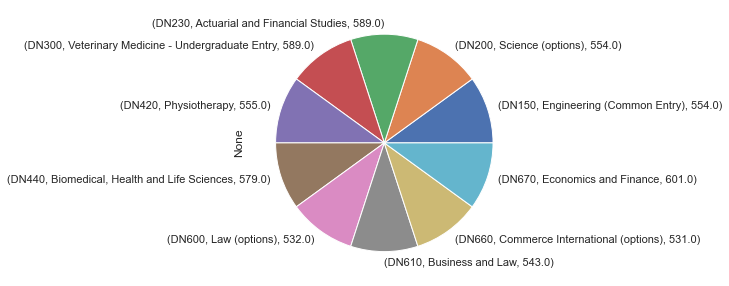

In [223]:
university_distribution(df2019_r1, 'Mid_2019', 'DN')

3. NUIG 

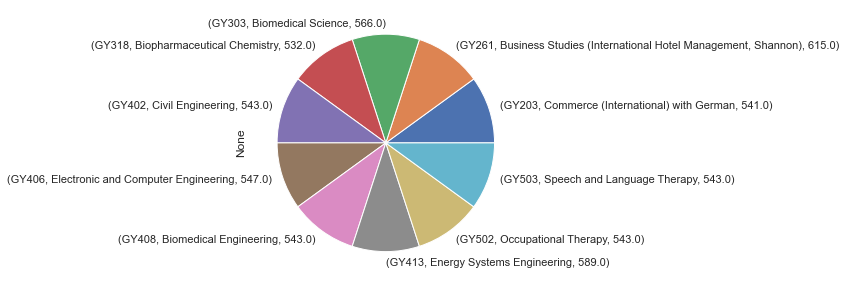

In [224]:
university_distribution(df2019_r1, 'Mid_2019', 'GY')

4. UCC

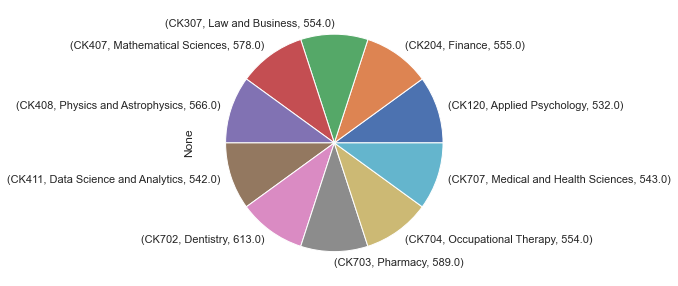

In [225]:
university_distribution(df2019_r1, 'Mid_2019', 'CK')

5. DCU

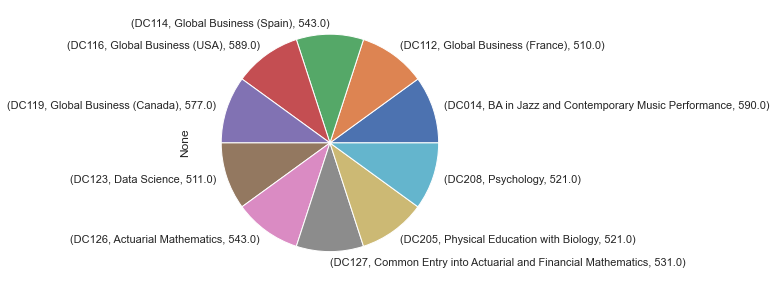

In [226]:
university_distribution(df2019_r1, 'Mid_2019', 'DC')

## Top Courses Displayed 2018

1. Trinity College Dublin

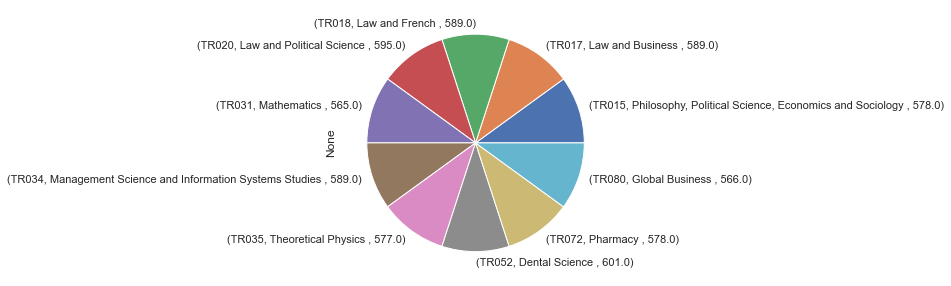

In [227]:
university_distribution(df2018_r1, 'Mid_2018', 'TR')

2. UCD

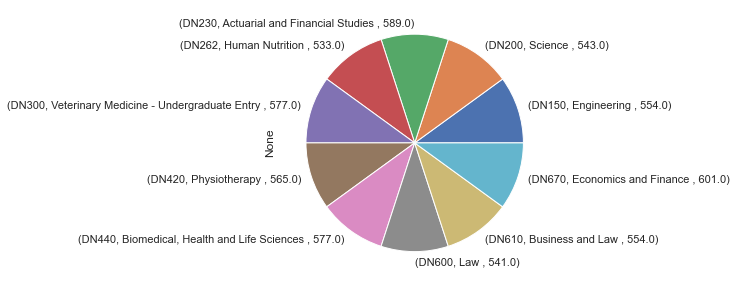

In [228]:
university_distribution(df2018_r1, 'Mid_2018', 'DN')

3. NUIG 

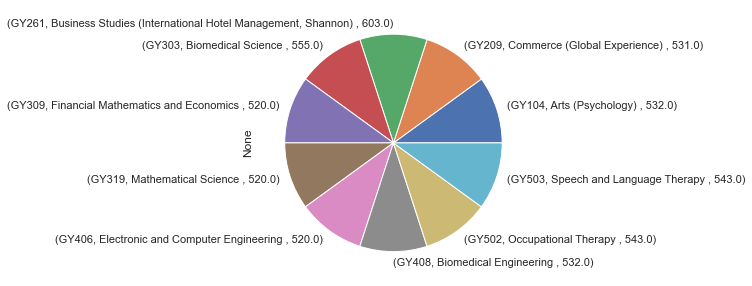

In [229]:
university_distribution(df2018_r1, 'Mid_2018', 'GY')

4. UCC

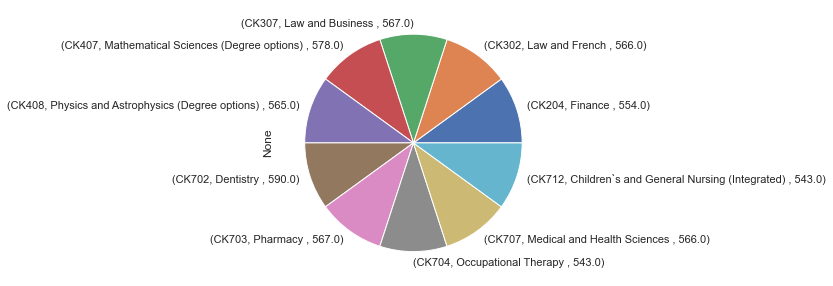

In [230]:
university_distribution(df2018_r1, 'Mid_2018', 'CK')

5. DCU

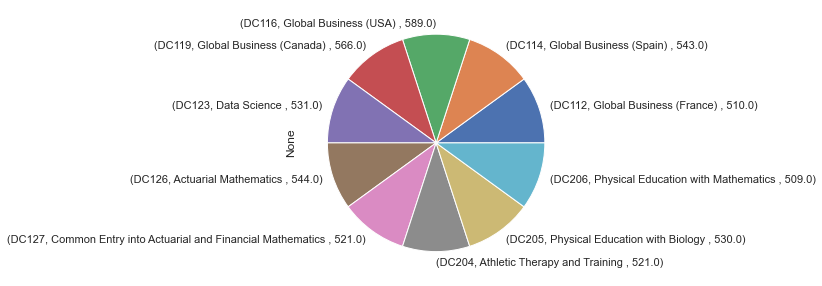

In [231]:
university_distribution(df2018_r1, 'Mid_2018', 'DC')

## Top Courses Displayed 2017

1. Trinity College Dublin

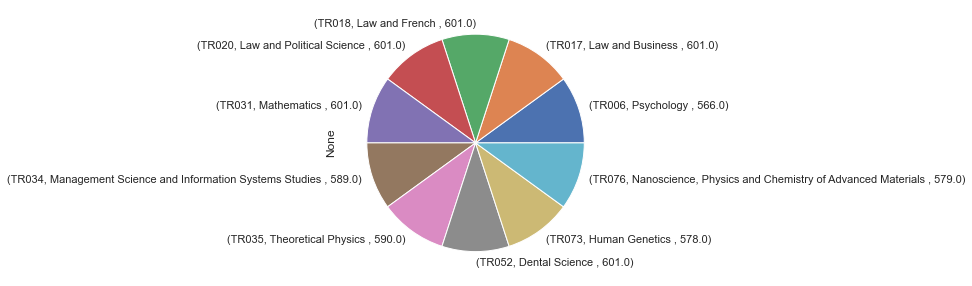

In [232]:
university_distribution(df2017_r1, 'Mid_2017', 'TR')

2. UCD

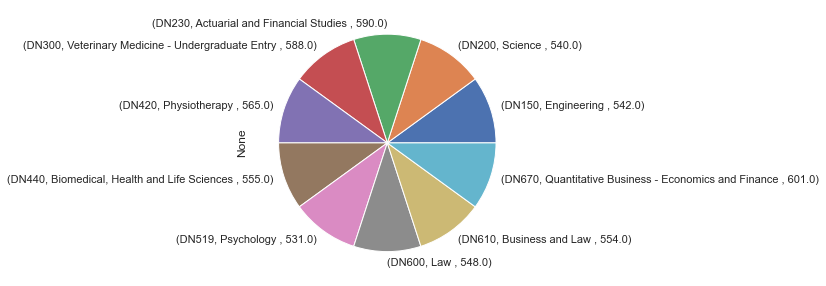

In [233]:
university_distribution(df2017_r1, 'Mid_2017', 'DN')

3. NUIG 

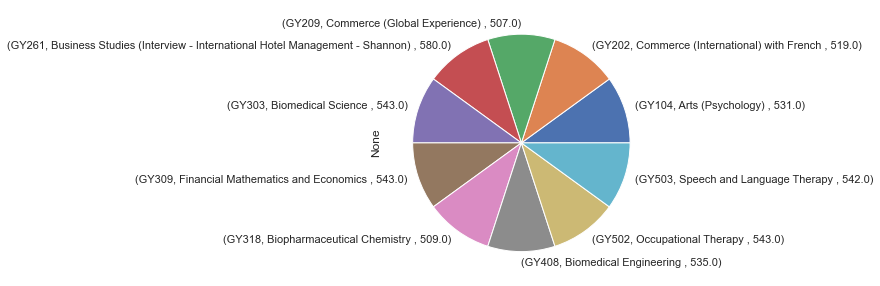

In [234]:
university_distribution(df2017_r1, 'Mid_2017', 'GY')

4. UCC

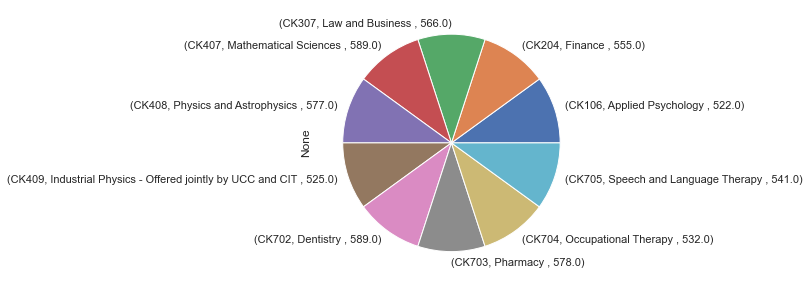

In [235]:
university_distribution(df2017_r1, 'Mid_2017', 'CK')

5. DCU 

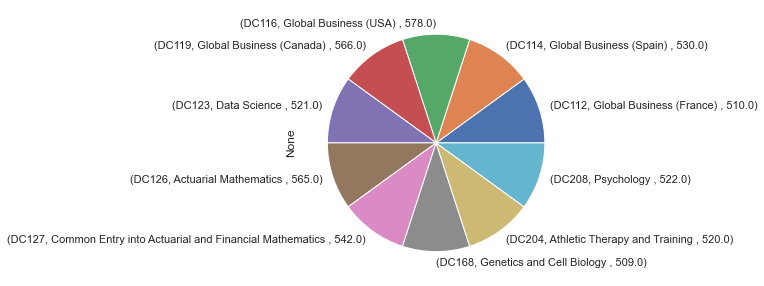

In [236]:
university_distribution(df2017_r1, 'Mid_2017', 'DC')

As seen from the Pie charts the same courses are the most in demand courses over the last 5 years. As we are just focusing on the most in demand courses and not comparing the increase in points I have choosen to look at 2021 - 2017 inclusive.

1. **Trinity**

TR052, TR034 were in the top 10 courses for all 5 years of data, with TR006, TR080, TR072, TR035, TR017, and TR020 appearing in the top 10 courses for four out of the five years.

2. **UCD**

DN230,DN200, DN670, DN610, DN600, DN420, DN300 were all in the top ten courses offered in UCD for all five years examined with DN150 appearing in the top ten four out of the five years examined

3. **NUIG**

GY503, GY502, GY303 were all in the top ten courses offered in NUIG for all five years examined with GY209 and GY408 appearing in the top ten four out of the five years examined. 

4. **UCC**

CK307, CK704, CK703, CK702, CK408, CK407 were in the top 10 courses for all 5 years of data, with CK707 appearing in the top 10 courses for four out of the five years.

5. **DCU**

DC114, DC112, DC126, DC119, DC116 were in the top 10 courses for all 5 years of data, with DC208 and DC127 appearing in the top 10 courses for four out of the five years.


# Conclusion
The data indicates a general increase in the points required for the courses with the highest points requirements. For the top univeristies in Ireland there is a trend showing the most in demand courses appear in the highest points for all five years examined. Had the data been synonomous a clearer picture may have emerged of an overall increase in the points required to gain entry to the top courses. As I was only able to exmaine 2021 and 2020 and then separetky exmaine 2019, 2018 and 2017's data there is no way to definitively state that the points increased from 2017 to 2021. With only two years of synonomous data I also could not accurately predict if the points for the highest courses would indeed increase for 2022, this would have been nice addition to the analysis of this data.

# References
<sup>1</sup>[Central Applications Office](https://en.wikipedia.org/wiki/Central_Applications_Office)  
<sup>2</sup>[Irish Leaving Certificate Examination Points](https://www.cao.ie/index.php?page=scoring&s=lcepointsgrid)  
<sup>3</sup>[Requests:HTTP for Humans](https://docs.python-requests.org/en/latest/)  
<sup>4</sup>[Requests:Quickstart](https://docs.python-requests.org/en/latest/user/quickstart/)  
<sup>5</sup>[200 OK](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/200)  
<sup>6</sup>[Top Universities](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi88b27sYz1AhX4QUEAHUUrBAUQFnoECAQQAQ&url=https%3A%2F%2Fwww.topuniversities.com%2Funiversity-rankings-articles%2Fworld-university-rankings%2Ftop-universities-ireland-2021&usg=AOvVaw1J-WeQWPZ8DxnDsLJlPn9z)  

# End